In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 80

train = pd.read_csv('./trainWithQualE.csv')
test = pd.read_csv('./testWithQualE.csv')

In [2]:
# Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the 
# predicted value and the logarithm of the observed sales price. (Taking logs means that 
# errors in predicting expensive houses and cheap houses will affect the result equally.)

def rmse(predictions, targets):
    predictions = np.log(predictions)
    targets = np.log(targets)
    return np.sqrt(((predictions - targets) ** 2).mean())

In [3]:
# Train test split with choice of test_size, scaler, lower and upper bounds to clip outliers.
# Check the ranks of the matrices we will pass into the linear regression

def checkRanksHelper(X, scaler, features, lower_clip, upper_clip):
    X_scaled = scaler.fit_transform(X.to_numpy())
    X_scaled_df = pd.DataFrame(X_scaled, columns=features)
    X_scaled_df = X_scaled_df.clip(lower_clip, upper_clip)
    X_scaled_final = X_scaled_df.to_numpy()
    return X_scaled_final

def checkRanksofFeatureMatrices(frame, features, target_values, test_size, scaler, lower_clip, upper_clip):
    X_train, X_test, y_train, y_test = train_test_split(frame[features], target_values, test_size = test_size)
    
    X_train_scaled = checkRanksHelper(X_train, scaler, features, lower_clip, upper_clip)
    print(X_train_scaled.shape)
    print(np.linalg.matrix_rank(X_train_scaled))
    
    X_test_scaled = checkRanksHelper(X_test, scaler, features, lower_clip, upper_clip)
    print(X_test_scaled.shape)
    print(np.linalg.matrix_rank(X_test_scaled))
    
    return X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled

In [4]:
# Plot the coefficients of a linear model

def plotCoeffs(features, coefficients):
    
    coeffs = pd.DataFrame()
    coeffs['features'] = features
    coeffs['coefficients'] = coefficients
    coeffs = coeffs.sort_values('coefficients', ascending=False)
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=coeffs, y='features', x='coefficients', orient='h')
    print(coeffs)

In [5]:
# You have to log transform your target variables. This is because we take RMSE on the logs of the 
# predicted prices, so we can never predict a negative price. We get around this issue by fitting
# a model on the log of SalePrice, which can be negative. However, e^(anything) is always positive
# so we get a positive SalePrice to plug into RMSE.

def OLS(X_train_scaled, X_test_scaled, y_train, y_test, features):
    reg = linear_model.LinearRegression().fit(X_train_scaled, np.log(y_train))
    
    plotCoeffs(features, reg.coef_)
    
    y_train_pred = reg.predict(X_train_scaled)
    print("Train Error: ", rmse(np.exp(y_train_pred), y_train))
    y_test_pred = reg.predict(X_test_scaled)
    print("Test Error: ", rmse(np.exp(y_test_pred), y_test))

In [6]:
# You can't send all the quantitative and qualitative variables into ordinary linear regression because the 
# feature matrix doesn't have full rank.

quantandqualE = [f for f in train.columns if train.dtypes[f] != 'object']
quantandqualE.remove('SalePrice')
quantandqualE.remove('Id')

myStandardScaler = StandardScaler()
X_train1, X_test1, y_train1, y_test1, X_train1_scaled, X_test1_scaled = checkRanksofFeatureMatrices(
    train, quantandqualE, train['SalePrice'].values, 0.25, myStandardScaler, -2, 3)

(1095, 79)
79
(365, 79)
78


           features  coefficients
31         PoolArea  6.461290e+11
10      TotalBsmtSF  1.676214e-01
14        GrLivArea  1.476168e-01
40      Utilities_E  9.933330e-02
2       OverallQual  6.816442e-02
43   Neighborhood_E  5.675970e-02
3       OverallCond  4.592675e-02
36         Street_E  3.879675e-02
78  SaleCondition_E  3.704701e-02
63     CentralAir_E  2.808562e-02
49       RoofMatl_E  2.557075e-02
24       GarageCars  2.469228e-02
55     Foundation_E  2.412042e-02
66     Functional_E  2.176222e-02
71     GarageCond_E  2.018453e-02
54      ExterCond_E  1.945683e-02
22       Fireplaces  1.822492e-02
34     MSSubClass_E  1.821508e-02
65    KitchenQual_E  1.767635e-02
32          MiscVal  1.708710e-02
72     PavedDrive_E  1.703132e-02
29        3SsnPorch  1.628368e-02
57       BsmtCond_E  1.603811e-02
17         FullBath  1.535773e-02
28    EnclosedPorch  1.534454e-02
39    LandContour_E  1.506752e-02
18         HalfBath  1.363402e-02
0       LotFrontage  1.294605e-02
26       WoodD

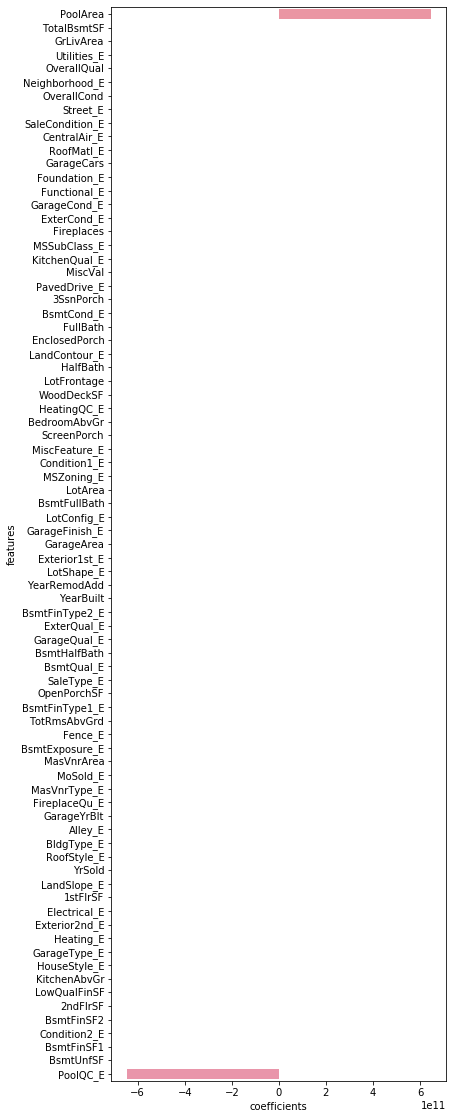

In [7]:
# Some of the coefficients got really big while some of the coefficients shrank to nothing. 
# Compare to linear regression with a full rank matrix, where the coefficients have the same
# order of magnitude.

OLS(X_train1_scaled, X_test1_scaled, y_train1, y_test1, quantandqualE)

In [8]:
# Plot average RMSE across each of the test folds as alpha varies. Necessary for Lasso, Ridge, and ElasticNet 
# as they have alphas that need to be tuned

def plotRMSEVersusAlpha(alphas, best_alpha, mse_path, axis):
    plt.plot(
        alphas, 
        np.sqrt(mse_path).mean(axis=axis),
        color="black",
        label = "Avg across the folds",
        linewidth = 2
    )
    
    plt.axvline(best_alpha, linestyle = "--", color="black", label="alpha CV est")

    plt.xlabel(r"$\alpha$")
    plt.ylabel("RMSE")
    plt.legend()
    plt.title("RMSE Versus Alpha")

In [9]:
# Fit Lasso with cross-validation to tune alpha.  

def myLassoCV(X_train_scaled, y_train, X_test_scaled, y_test, alphas, features):
    lasso = LassoCV(cv=5, alphas=alphas, max_iter=10000).fit(X_train_scaled, np.log(y_train))
    plotCoeffs(features, lasso.coef_) 
    y_train_pred = lasso.predict(X_train_scaled)
    print("Train Error: ", rmse(np.exp(y_train_pred), y_train))
    y_test_pred = lasso.predict(X_test_scaled)
    print("Test Error: ", rmse(np.exp(y_test_pred), y_test))
    return lasso

           features  coefficients
14        GrLivArea      0.122612
2       OverallQual      0.064988
43   Neighborhood_E      0.054482
3       OverallCond      0.050911
10      TotalBsmtSF      0.048475
63     CentralAir_E      0.035399
24       GarageCars      0.032441
7        BsmtFinSF1      0.030922
78  SaleCondition_E      0.030065
49       RoofMatl_E      0.026724
35       MSZoning_E      0.021332
65    KitchenQual_E      0.019398
4         YearBuilt      0.017763
66     Functional_E      0.017626
1           LotArea      0.016090
30      ScreenPorch      0.015556
17         FullBath      0.013650
67    FireplaceQu_E      0.013418
71     GarageCond_E      0.012734
55     Foundation_E      0.012525
44     Condition1_E      0.011434
58   BsmtExposure_E      0.011073
11         1stFlrSF      0.010900
0       LotFrontage      0.009755
62      HeatingQC_E      0.009045
15     BsmtFullBath      0.008452
22       Fireplaces      0.007407
34     MSSubClass_E      0.007139
18         Hal

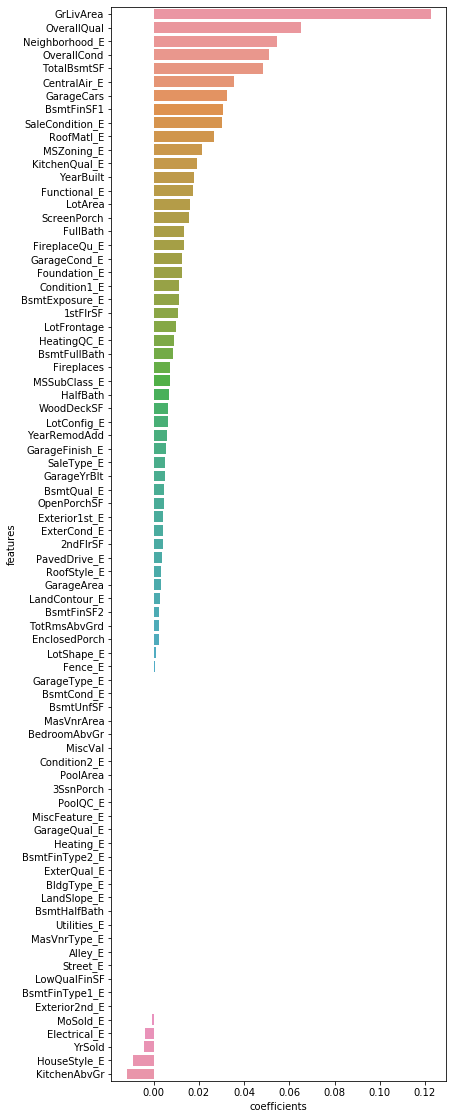

In [10]:
# Lasso with Standard Scaling. 

# Train Error:  0.12564152264979958
# Test Error:  0.10209485127141181

# Note that the mean/middle category of some qualitative encoded features were
# sometimes scaled negatively. For example, category 5 (1Story) of HouseStyle_E 
# was scaled negative with StandardScaling.

# For this reason, the lasso model coefficient of qualitative encoded conditions 
# is sometimes negative even though the qualitative encoding is such that increasing
# values corresponding to increasing SalePrice.

alphas = np.linspace(0.0001, 0.005, num=100)
lasso = myLassoCV(X_train1_scaled, y_train1, X_test1_scaled, y_test1, alphas, quantandqualE)

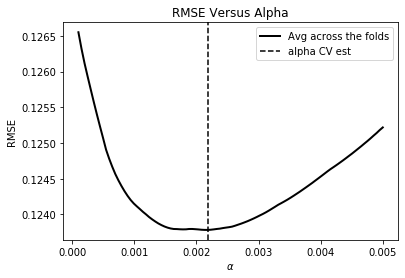

In [11]:
# Plot the average RMSE across each of the 5 test folds as alpha varies.

plotRMSEVersusAlpha(lasso.alphas_, lasso.alpha_, lasso.mse_path_, -1)

In [12]:
def singleError(row):
    return (np.log(row['Predicted']) - np.log(row['Actual'])) ** 2

def overEstimate(row):
    answer = 1 if row['Predicted'] > row['Actual'] else 0
    return answer

def difficultExamples(X_test, y_test, model, X_test_scaled):
    df = X_test.copy()
    y_test_pred = model.predict(X_test_scaled)
    df['Predicted'] = np.exp(y_test_pred)
    df['Actual'] = y_test
    df['OverEstimate'] = df.apply(lambda row: overEstimate(row), axis=1)
    df['Error'] = df.apply(lambda row: singleError(row), axis=1)
    df = df.sort_values('Error', ascending=False)
    print("Test Error: ", np.sqrt(np.mean(df['Error'])))
    print('Percent Overestimate: ', np.sum(df['OverEstimate'])/df.shape[0])
    return df

In [13]:
# We have a slight tendency to overestimate.

test_df = difficultExamples(X_test1, y_test1, lasso, X_test1_scaled)
test_df.head()

Test Error:  0.13604351772025908
Percent Overestimate:  0.4986301369863014


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,MSSubClass_E,MSZoning_E,Street_E,Alley_E,LotShape_E,LandContour_E,...,Neighborhood_E,Condition1_E,Condition2_E,BldgType_E,HouseStyle_E,RoofStyle_E,RoofMatl_E,Exterior1st_E,Exterior2nd_E,MasVnrType_E,ExterQual_E,ExterCond_E,Foundation_E,BsmtQual_E,BsmtCond_E,BsmtExposure_E,BsmtFinType1_E,BsmtFinType2_E,Heating_E,HeatingQC_E,CentralAir_E,Electrical_E,KitchenQual_E,Functional_E,FireplaceQu_E,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,MoSold_E,SaleType_E,SaleCondition_E,Predicted,Actual,OverEstimate,Error
523,130.0,40094,10,5,2007,2008,762.0,2260,0,878,3138,3138,1538,0,4676,1,0,3,1,3,1,11,1,2007.0,3,884,208,406,0,0,0,0,0,2007,15,4,2,2,2,1,...,5,7,7,4,7,4,3,13,15,4,4,5,6,5,4,5,7,5,6,5,2,5,4,7,5,7,4,5,6,3,1,5,3,4,8,6,570977.899847,184750,1,1.273167
632,85.0,11900,7,5,1977,1977,209.0,822,0,564,1386,1411,0,0,1411,0,0,2,0,3,1,6,1,1977.0,2,544,192,0,0,0,0,0,0,2009,11,4,2,2,1,2,...,15,4,5,4,5,4,3,11,11,3,2,3,4,3,4,2,5,5,6,3,2,5,2,7,4,6,4,5,6,3,1,5,3,1,6,3,173596.441305,82500,1,0.553439
495,60.0,7879,4,5,1920,1950,0.0,495,0,225,720,720,0,0,720,0,0,1,0,2,1,4,0,1920.0,0,0,0,523,115,0,0,0,0,2009,2,1,2,2,1,2,...,2,4,5,4,5,2,3,6,3,2,2,5,4,3,4,2,4,5,6,3,1,4,2,7,2,1,1,2,1,1,1,3,3,8,6,2,67176.598899,34900,1,0.428813
1324,75.0,9986,8,5,2006,2007,428.0,0,0,1795,1795,1795,0,0,1795,0,0,2,0,2,1,7,1,2007.0,3,895,0,49,0,0,0,0,0,2007,11,4,2,2,1,2,...,21,4,5,4,5,2,3,12,14,3,3,5,6,5,4,4,6,5,6,5,2,5,3,7,5,6,3,5,6,3,1,5,3,9,8,6,279962.739451,147000,1,0.415024
588,65.0,25095,5,8,1968,2003,0.0,1324,0,113,1437,1473,0,0,1473,2,0,1,0,1,1,5,2,1968.0,1,452,0,48,0,0,60,0,0,2009,11,4,2,2,2,3,...,18,4,5,4,5,5,4,6,3,2,2,5,4,3,4,5,7,5,6,5,2,5,4,7,5,6,2,5,6,3,1,5,3,5,6,6,270223.254661,143000,1,0.405010


In [14]:
def difficultExamplesScaled(X_test_scaled, y_test, model, features):
    df = pd.DataFrame(X_test_scaled, columns=features)
    y_test_pred = model.predict(X_test_scaled)
    df['Predicted'] = np.exp(y_test_pred)
    df['Actual'] = y_test
    df['OverEstimate'] = df.apply(lambda row: overEstimate(row), axis=1)
    df['Error'] = df.apply(lambda row: singleError(row), axis=1)
    df = df.sort_values('Error', ascending=False)
    print("Test Error: ", np.sqrt(np.mean(df['Error'])))
    print('Percent Overestimate: ', np.sum(df['OverEstimate'])/df.shape[0])
    return df

In [15]:
test_df_scaled = difficultExamplesScaled(X_test1_scaled, y_test1, lasso, quantandqualE)
test_df_scaled.head()

Test Error:  0.13604351772025908
Percent Overestimate:  0.4986301369863014


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,MSSubClass_E,MSZoning_E,Street_E,Alley_E,LotShape_E,LandContour_E,...,Neighborhood_E,Condition1_E,Condition2_E,BldgType_E,HouseStyle_E,RoofStyle_E,RoofMatl_E,Exterior1st_E,Exterior2nd_E,MasVnrType_E,ExterQual_E,ExterCond_E,Foundation_E,BsmtQual_E,BsmtCond_E,BsmtExposure_E,BsmtFinType1_E,BsmtFinType2_E,Heating_E,HeatingQC_E,CentralAir_E,Electrical_E,KitchenQual_E,Functional_E,FireplaceQu_E,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,MoSold_E,SaleType_E,SaleCondition_E,Predicted,Actual,OverEstimate,Error
239,3.000000,3.000000,2.840064,-0.491744,1.224751,1.171933,3.000000,3.000000,-0.295,0.818658,3.000000,3.000000,2.733313,-0.113032,3.000000,1.108109,-0.276941,2.686087,1.247075,0.158008,-0.227757,2.883488,0.649523,1.202565,1.599794,2.006001,1.067742,3.000000,-0.386911,-0.123108,-0.291923,0.0,-0.086218,-0.638926,1.222849,0.320418,0.0,0.0824,0.925341,-2.000000,...,-1.185375,3.000000,3.000000,0.109612,1.113442,1.781377,-0.115924,1.380528,1.316438,2.344738,2.742626,0.387853,1.001833,1.862571,0.078757,2.166062,1.010898,0.294242,0.129279,0.906176,0.276941,0.296272,2.258839,0.255408,1.316360,1.253648,1.482029,0.315582,0.328017,0.288067,0.0,0.443972,0.111726,-0.561801,2.110129,1.337594,570977.899847,184750,1,1.273167
88,0.799525,0.317190,0.674416,-0.491744,0.202102,-0.321190,0.632095,0.843896,-0.295,0.054587,0.856587,0.735317,-0.833524,-0.113032,-0.198214,-0.845803,-0.276941,0.807884,-0.749339,0.158008,-0.227757,-0.305824,0.649523,0.071189,0.305060,0.383514,0.929758,-0.712078,-0.386911,-0.123108,-0.291923,0.0,-0.086218,0.855997,0.178168,0.320418,0.0,0.0824,-0.652928,-0.036048,...,0.304507,0.171615,0.011423,0.109612,-0.125602,1.781377,-0.115924,0.631802,0.411542,0.835339,-0.691537,-2.000000,-0.469672,-0.674140,0.078757,-0.611266,-0.181276,0.294242,0.129279,-1.148198,0.276941,0.296272,-0.750198,0.255408,0.570286,0.675894,1.482029,0.315582,0.328017,0.288067,0.0,0.443972,0.111726,-1.546078,-0.002895,-2.000000,173596.441305,82500,1,0.553439
329,-0.464669,-0.404081,-1.491231,-0.491744,-1.740932,-1.621652,-0.527331,0.103099,-0.295,-0.770318,-0.791501,-1.181997,-0.833524,-0.113032,-1.566937,-0.845803,-0.276941,-1.070318,-0.749339,-1.095748,-0.227757,-1.581549,-0.941590,-2.000000,-2.000000,-2.000000,-0.726044,3.000000,1.471067,-0.123108,-0.291923,0.0,-0.086218,0.855997,-2.000000,-2.000000,0.0,0.0824,-0.652928,-0.036048,...,-1.632340,0.171615,0.011423,0.109612,-0.125602,-0.488091,-0.115924,-1.240014,-1.398251,-0.674060,-0.691537,0.387853,-0.469672,-0.674140,0.078757,-0.611266,-0.777363,0.294242,0.129279,-1.148198,-2.000000,-2.000000,-0.750198,0.255408,-0.921861,-2.000000,-1.870909,-2.000000,-2.000000,-2.000000,0.0,-1.520268,0.111726,0.750567,-0.002895,-2.000000,67176.598899,34900,1,0.428813
127,0.293847,-0.026136,1.396299,-0.491744,1.190663,1.123768,1.846997,-1.018291,-0.295,3.000000,1.868701,1.800799,-0.833524,-0.113032,0.562407,-0.845803,-0.276941,0.807884,-0.749339,-1.095748,-0.227757,0.332038,0.649523,1.202565,1.599794,2.058493,-0.726044,-0.023188,-0.386911,-0.123108,-0.291923,0.0,-0.086218,-0.638926,0.178168,0.320418,0.0,0.0824,-0.652928,-0.036048,...,1.198437,0.171615,0.011423,0.109612,-0.125602,-0.488091,-0.115924,1.006165,1.090214,0.835339,1.025545,0.387853,1.001833,1.862571,0.078757,1.240286,0.414811,0.294242,0.129279,0.906176,0.276941,0.296272,0.754320,0.255408,1.316360,0.675894,0.364383,0.315582,0.328017,0.288067,0.0,0.443972,0.111726,1.078659,2.110129,1.337594,279962.739451,147000,1,0.415024
355,-0.211830,2.684059,-0.769349,2.269589,-0.104693,0.931107,-0.527331,1.981143,-0.295,-1.042853,0.982792,0.907348,-0.833524,

In [16]:
def singleWeight(row):
    return row['model coeffs'] * row['scaled values']

def understandCoefficients(features, model, test_df_scaled, test_df, index):
    df = pd.DataFrame()
    df['features'] = features
    df['model coeffs'] = model.coef_
    
    scaled_values = test_df_scaled.iloc[index].to_numpy()
    scaled_values = scaled_values[0:-4]
    df['scaled values'] = scaled_values
    
    actual_values = test_df.iloc[index].to_numpy()
    actual_values = actual_values[0:-4]
    df['actual values'] = actual_values
    
    df['Weight'] = df.apply(lambda row: singleWeight(row), axis=1)
    df = df.sort_values('Weight', ascending=False)
    return df

In [17]:
# We under-estimated the price as $121K when the actual price was $179K. 
# Due to scaling, we might not have valued the tricked-out basement as
# highly as we should have

understand_0 = understandCoefficients(quantandqualE, lasso, test_df_scaled, test_df, 0)
understand_0.head(n=100)

,features,model coeffs,scaled values,actual values,Weight
14,GrLivArea,0.122612,3.000000,4676.0,0.367836
2,OverallQual,0.064988,2.840064,10.0,0.184571
10,TotalBsmtSF,0.048475,3.000000,3138.0,0.145424
7,BsmtFinSF1,0.030922,3.000000,2260.0,0.092765
24,GarageCars,0.032441,1.599794,3.0,0.051899
1,LotArea,0.016090,3.000000,40094.0,0.048270
65,KitchenQual_E,0.019398,2.258839,4.0,0.043817
78,SaleCondition_E,0.030065,1.337594,6.0,0.040215
17,FullBath,0.013650,2.686087,3.0,0.036665
44,Condition1_E,0.011434,3.000000,7.0,0.034301


In [22]:
def checkRanksofFeatureMatricesNoSplit(train, test, features, scaler, lower_clip, upper_clip):
    X_train_scaled = checkRanksHelper(train[features], scaler, features, lower_clip, upper_clip)
    print(X_train_scaled.shape)
    print(np.linalg.matrix_rank(X_train_scaled))
    
    X_test_scaled = checkRanksHelper(test[features], scaler, features, lower_clip, upper_clip)
    print(X_test_scaled.shape)
    print(np.linalg.matrix_rank(X_test_scaled))
    
    return X_train_scaled, X_test_scaled

In [22]:
X_train_scaled_final, X_test_scaled_final = checkRanksofFeatureMatricesNoSplit(
    train, test, quantandqualE, myStandardScaler, -2, 3)

(1460, 79)
79
(1459, 79)
78


In [23]:
# Fit Lasso with cross-validation to tune alpha.  

def myLassoCVFinal(X_train_scaled, y_train, alphas, features):   
    lasso = LassoCV(cv=5, alphas=alphas, max_iter=10000).fit(X_train_scaled, np.log(y_train))
    plotCoeffs(features, lasso.coef_) 
    y_train_pred = lasso.predict(X_train_scaled)
    print("Train Error: ", rmse(np.exp(y_train_pred), y_train))
    return lasso

           features  coefficients
14        GrLivArea      0.127411
2       OverallQual      0.071413
43   Neighborhood_E      0.059920
3       OverallCond      0.047257
10      TotalBsmtSF      0.039015
24       GarageCars      0.031573
78  SaleCondition_E      0.030458
7        BsmtFinSF1      0.030394
63     CentralAir_E      0.025066
66     Functional_E      0.018870
35       MSZoning_E      0.018428
65    KitchenQual_E      0.016160
62      HeatingQC_E      0.013976
30      ScreenPorch      0.013700
4         YearBuilt      0.012571
11         1stFlrSF      0.012191
71     GarageCond_E      0.011821
1           LotArea      0.010744
55     Foundation_E      0.010732
58   BsmtExposure_E      0.010013
15     BsmtFullBath      0.009920
67    FireplaceQu_E      0.009397
5      YearRemodAdd      0.009228
26       WoodDeckSF      0.008737
22       Fireplaces      0.008727
44     Condition1_E      0.008417
0       LotFrontage      0.007621
39    LandContour_E      0.007461
34     MSSubCl

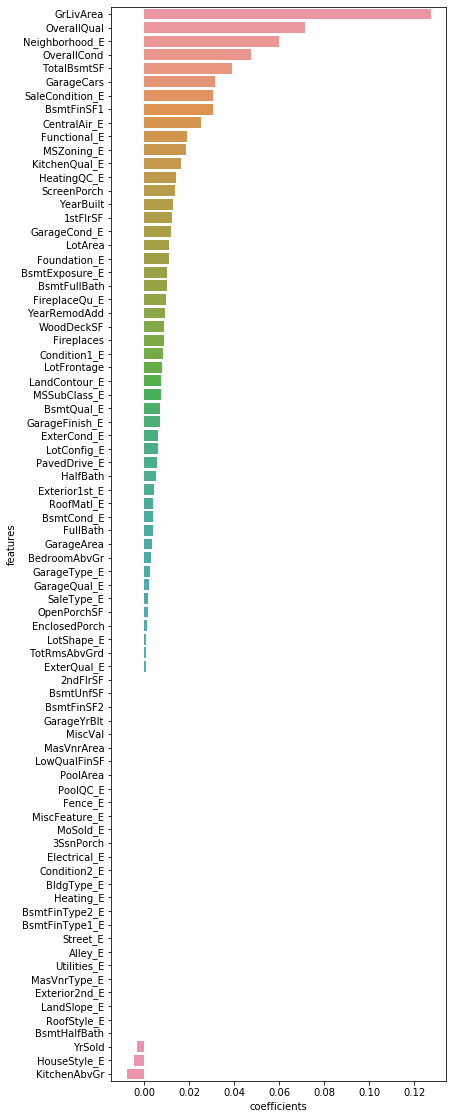

In [27]:
lassoFinal = myLassoCVFinal(X_train_scaled_final, train['SalePrice'], alphas, quantandqualE)

In [24]:
def modelPredict(X_test_scaled, model, frame, label, expornot):
    y_pred = model.predict(X_test_scaled)
    answer = np.exp(y_pred) if expornot else y_pred
    frame['SalePrice'] = answer
    Submission = frame[['Id', 'SalePrice']]
    Submission.to_csv('/home/seasnake/Desktop/Kaggle_Housing/sub' + label + '.csv', index=False)
    return frame

In [123]:
testFinal = test.copy()
modelPredict(X_test_scaled_final, lassoFinal, testFinal, 'lassoOutliersClipped', True)
testFinal.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Utilities_E,LotConfig_E,LandSlope_E,Neighborhood_E,Condition1_E,Condition2_E,BldgType_E,HouseStyle_E,RoofStyle_E,RoofMatl_E,Exterior1st_E,Exterior2nd_E,MasVnrType_E,ExterQual_E,ExterCond_E,Foundation_E,BsmtQual_E,BsmtCond_E,BsmtExposure_E,BsmtFinType1_E,BsmtFinType2_E,Heating_E,HeatingQC_E,CentralAir_E,Electrical_E,KitchenQual_E,Functional_E,FireplaceQu_E,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,MoSold_E,SaleType_E,SaleCondition_E,SalePrice
0,1461,SC20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,...,2,1,1,10,2,5,4,5,2,3,12,14,2,2,5,4,3,4,2,4,4,6,3,2,5,2,7,2,6,2,5,6,3,1,2,3,5,6,5,118554.308934
1,1462,SC20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,...,2,2,1,10,4,5,4,5,4,3,6,3,3,2,5,4,3,4,2,5,5,6,3,2,5,3,7,2,6,2,5,6,3,1,5,4,5,6,5,161338.942027
2,1463,SC60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,...,2,1,1,14,4,5,4,7,2,3,12,14,2,2,5,6,4,4,2,7,5,6,4,2,5,2,7,4,6,4,5,6,3,1,2,3,7,6,5,177406.481903
3,1464,SC60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,...,2,1,1,14,4,5,4,7,2,3,12,14,3,2,5,6,3,4,2,7,5,6,5,2,5,3,7,5,6,4,5,6,3,1,5,3,5,6,5,198872.192685
4,1465,SC120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,...,2,1,1,23,4,5,5,5,2,3,9,9,2,3,5,6,4,4,2,5,5,6,5,2,5,3,7,2,6,3,5,6,3,1,5,3,2,6,5,204745.201330


In [21]:
trainExp = pd.read_csv('/home/seasnake/Desktop/Kaggle_Housing/trainExpensiveWithQualE.csv')
trainMid = pd.read_csv('/home/seasnake/Desktop/Kaggle_Housing/trainMidWithQualE.csv')
trainCheap = pd.read_csv('/home/seasnake/Desktop/Kaggle_Housing/trainCheapWithQualE.csv')
testExp = pd.read_csv('/home/seasnake/Desktop/Kaggle_Housing/testExpensiveWithQualE.csv')
testMid = pd.read_csv('/home/seasnake/Desktop/Kaggle_Housing/testMidWithQualE.csv')
testCheap = pd.read_csv('/home/seasnake/Desktop/Kaggle_Housing/testCheapWithQualE.csv')

In [34]:
X_train_Exp1, X_test_Exp1, y_train_Exp1, y_test_Exp1, X_train_Exp_scaled1, X_test_Exp_scaled1 = checkRanksofFeatureMatrices(
    trainExp, quantandqualE, trainExp['SalePrice'].values, 0.25, myStandardScaler, -2, 3)

(192, 79)
67
(65, 79)
63


           features  coefficients
14        GrLivArea      0.121761
10      TotalBsmtSF      0.054965
1           LotArea      0.052824
2       OverallQual      0.051772
7        BsmtFinSF1      0.036975
77       SaleType_E      0.029669
58   BsmtExposure_E      0.019946
21     TotRmsAbvGrd      0.012960
25       GarageArea      0.012208
5      YearRemodAdd      0.012107
6        MasVnrArea      0.011905
34     MSSubClass_E      0.010991
15     BsmtFullBath      0.010973
67    FireplaceQu_E      0.010920
65    KitchenQual_E      0.008689
23      GarageYrBlt      0.008615
30      ScreenPorch      0.008094
56       BsmtQual_E      0.007889
27      OpenPorchSF      0.007499
76         MoSold_E      0.005190
17         FullBath      0.003427
0       LotFrontage      0.003103
37          Alley_E      0.001799
38       LotShape_E      0.001216
59   BsmtFinType1_E      0.001211
22       Fireplaces      0.001142
18         HalfBath      0.001099
51    Exterior2nd_E      0.000000
52     MasVnrT

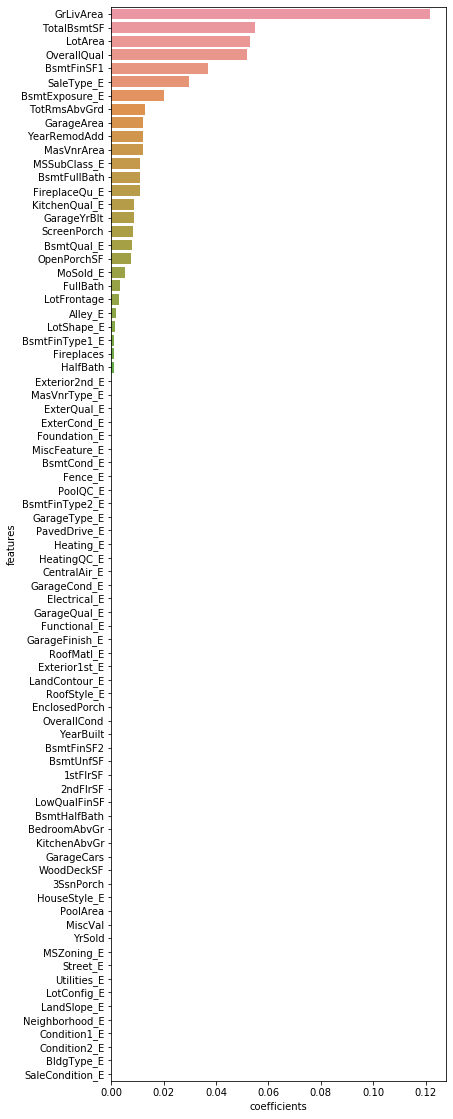

In [37]:
# Lasso with Standard Scaling on Expensive Houses

# Train Error:  0.08701546987267768
# Test Error:  0.12464526564930677

# Seems to be some overfitting because I plugged in all the features.

expAlphas = np.linspace(0.001, 0.01, num=100)
lassoExp = myLassoCV(X_train_Exp_scaled1, y_train_Exp1, X_test_Exp_scaled1, y_test_Exp1, expAlphas, quantandqualE)

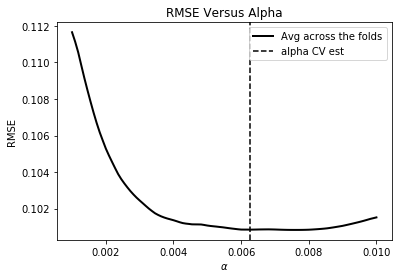

In [38]:
# Plot the average RMSE across each of the 5 test folds as alpha varies.

plotRMSEVersusAlpha(lassoExp.alphas_, lassoExp.alpha_, lassoExp.mse_path_, -1)

In [24]:
selectedExpFeatures = ['GrLivArea', 'OverallQual', 'LotArea', 'GarageCars', 'BsmtQual_E', 
                       'KitchenQual_E', 'LotFrontage', 'BsmtFinSF1', 'MSSubClass_E', 'ExterQual_E', 
                       'MasVnrArea', 'RoofStyle_E', 'Neighborhood_E', 'BsmtExposure_E', 'GarageFinish_E', 
                       'MSZoning_E', 'GarageType_E']

In [54]:
X_train_Exp2, X_test_Exp2, y_train_Exp2, y_test_Exp2, X_train_Exp_scaled2, X_test_Exp_scaled2 = checkRanksofFeatureMatrices(
    trainExp, selectedExpFeatures, trainExp['SalePrice'].values, 0.25, myStandardScaler, -2, 3)

(192, 17)
17
(65, 17)
17


          features  coefficients
0        GrLivArea      0.094625
2          LotArea      0.062432
1      OverallQual      0.060814
7       BsmtFinSF1      0.052451
5    KitchenQual_E      0.031498
8     MSSubClass_E      0.028252
4       BsmtQual_E      0.023482
13  BsmtExposure_E      0.022663
3       GarageCars      0.019519
11     RoofStyle_E      0.014864
6      LotFrontage      0.011220
14  GarageFinish_E      0.010080
10      MasVnrArea      0.008453
12  Neighborhood_E      0.001250
9      ExterQual_E      0.000001
15      MSZoning_E      0.000000
16    GarageType_E     -0.000000
Train Error:  0.11129625053245328
Test Error:  0.13732255129813392


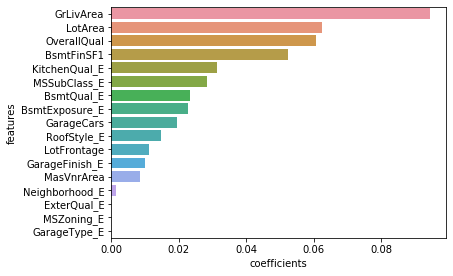

In [55]:
# Lasso with Standard Scaling on Expensive Houses

# Train Error:  0.11129625053245328
# Test Error:  0.13732255129813392

# Playing around with the number of features input into Lasso helped with overfitting

expAlphas2 = np.linspace(0.0001, 0.005, num=100)
lassoExp2 = myLassoCV(X_train_Exp_scaled2, y_train_Exp2, X_test_Exp_scaled2, y_test_Exp2, expAlphas2, selectedExpFeatures)

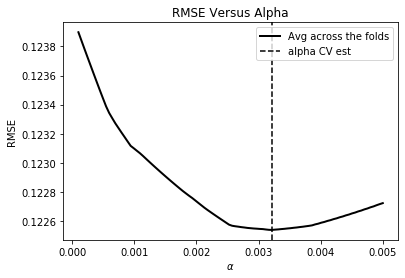

In [56]:
# Plot the average RMSE across each of the 5 test folds as alpha varies.

plotRMSEVersusAlpha(lassoExp2.alphas_, lassoExp2.alpha_, lassoExp2.mse_path_, -1)

In [59]:
# We are underestimating our outliers big time.

test_df_Exp = difficultExamples(X_test_Exp2, y_test_Exp2, lassoExp2, X_test_Exp_scaled2)
test_df_Exp.head()

Test Error:  0.13732255129813392
Percent Overestimate:  0.3384615384615385


,GrLivArea,OverallQual,LotArea,GarageCars,BsmtQual_E,KitchenQual_E,LotFrontage,BsmtFinSF1,MSSubClass_E,ExterQual_E,MasVnrArea,RoofStyle_E,Neighborhood_E,BsmtExposure_E,GarageFinish_E,MSZoning_E,GarageType_E,Predicted,Actual,OverEstimate,Error
155,2822,9,13891,3,3,3,107.0,0,5,3,424.0,2,6,4,2,3,3,381332.572666,582933,0,0.180116
168,2364,9,12919,3,3,3,100.0,2188,4,3,760.0,2,6,4,3,3,2,418044.206666,611657,0,0.144845
88,3228,8,12692,2,1,2,69.0,1231,4,2,0.0,2,5,1,2,3,2,321436.098599,430000,0,0.084673
213,4476,10,15623,3,3,3,160.0,2096,5,2,0.0,2,5,3,3,3,2,557493.478321,745000,0,0.084061
28,2234,9,17423,3,3,3,63.0,1904,4,3,748.0,2,4,1,3,3,2,387442.402958,501837,0,0.066930


In [60]:
X_train_Exp3, X_test_Exp3, y_train_Exp3, y_test_Exp3, X_train_Exp_scaled3, X_test_Exp_scaled3 = checkRanksofFeatureMatrices(
    trainExp, selectedExpFeatures, trainExp['SalePrice'].values, 0.25, myStandardScaler, -3, 4)

(192, 17)
17
(65, 17)
17


          features  coefficients
0        GrLivArea      0.113173
1      OverallQual      0.060559
7       BsmtFinSF1      0.058580
2          LotArea      0.042373
8     MSSubClass_E      0.038360
13  BsmtExposure_E      0.025674
4       BsmtQual_E      0.023602
5    KitchenQual_E      0.020787
6      LotFrontage      0.017294
9      ExterQual_E      0.016207
14  GarageFinish_E      0.014420
11     RoofStyle_E      0.012533
12  Neighborhood_E      0.010573
3       GarageCars      0.010554
10      MasVnrArea      0.006089
15      MSZoning_E      0.000000
16    GarageType_E     -0.000000
Train Error:  0.1148171920651275
Test Error:  0.10213270823999537


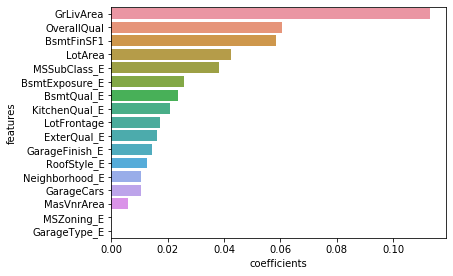

In [61]:
# Lasso with Standard Scaling on Expensive Houses. More Lenient Winsorizing.

# Train Error:  0.1148171920651275
# Test Error:  0.10213270823999537

# Playing around with the number of features input into Lasso helped with overfitting

expAlphas3 = np.linspace(0.0001, 0.005, num=100)
lassoExp3 = myLassoCV(X_train_Exp_scaled3, y_train_Exp3, X_test_Exp_scaled3, y_test_Exp3, expAlphas3, selectedExpFeatures)

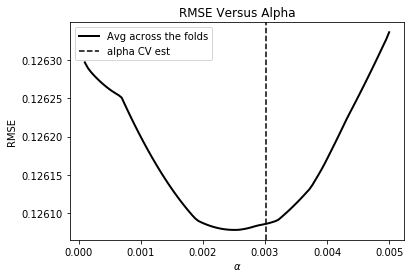

In [62]:
# Plot the average RMSE across each of the 5 test folds as alpha varies.

plotRMSEVersusAlpha(lassoExp3.alphas_, lassoExp3.alpha_, lassoExp3.mse_path_, -1)

In [63]:
# Now we have a tendency to overestimate

test_df_Exp3 = difficultExamples(X_test_Exp3, y_test_Exp3, lassoExp3, X_test_Exp_scaled3)
test_df_Exp3.head()

Test Error:  0.10213270823999533
Percent Overestimate:  0.6461538461538462


,GrLivArea,OverallQual,LotArea,GarageCars,BsmtQual_E,KitchenQual_E,LotFrontage,BsmtFinSF1,MSSubClass_E,ExterQual_E,MasVnrArea,RoofStyle_E,Neighborhood_E,BsmtExposure_E,GarageFinish_E,MSZoning_E,GarageType_E,Predicted,Actual,OverEstimate,Error
212,2872,8,10678,2,1,2,85.0,700,6,2,337.0,2,5,1,3,3,2,382745.076533,285000,1,0.086954
1,2198,8,14260,3,1,2,84.0,655,5,2,350.0,1,5,3,2,3,2,326896.555082,250000,1,0.071922
3,2324,9,11924,3,3,3,85.0,998,5,3,286.0,2,6,1,3,3,3,422317.686688,345000,1,0.040890
192,2868,9,16056,3,3,3,85.0,240,5,2,208.0,2,4,3,3,3,3,456077.910383,556581,0,0.039660
27,1767,7,5306,2,1,2,44.0,495,1,2,0.0,1,4,1,2,3,2,199480.007716,239000,0,0.032670


In [57]:
X_train_Mid1, X_test_Mid1, y_train_Mid1, y_test_Mid1, X_train_Mid_scaled1, X_test_Mid_scaled1 = checkRanksofFeatureMatrices(
    trainMid, quantandqualE, trainMid['SalePrice'].values, 0.25, myStandardScaler, -2, 3)

(289, 79)
77
(97, 79)
74


           features  coefficients
14        GrLivArea      0.133296
2       OverallQual      0.082421
10      TotalBsmtSF      0.042589
1           LotArea      0.040127
24       GarageCars      0.032137
3       OverallCond      0.031476
7        BsmtFinSF1      0.031205
43   Neighborhood_E      0.023910
70     GarageQual_E      0.021384
63     CentralAir_E      0.021370
62      HeatingQC_E      0.019734
35       MSZoning_E      0.019371
56       BsmtQual_E      0.017982
72     PavedDrive_E      0.014953
71     GarageCond_E      0.014239
5      YearRemodAdd      0.013265
78  SaleCondition_E      0.013043
12         2ndFlrSF      0.012869
57       BsmtCond_E      0.012775
58   BsmtExposure_E      0.011424
41      LotConfig_E      0.009654
22       Fireplaces      0.009524
50    Exterior1st_E      0.008724
15     BsmtFullBath      0.007995
16     BsmtHalfBath      0.007183
67    FireplaceQu_E      0.006969
44     Condition1_E      0.006786
29        3SsnPorch      0.006709
64     Electri

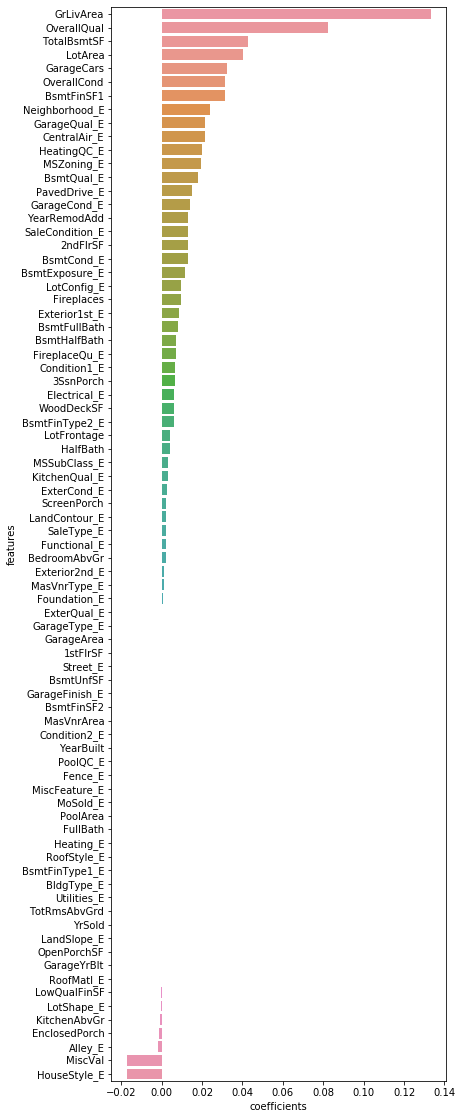

In [64]:
# Lasso with Standard Scaling on Mid Houses

# Train Error:  0.0972578709881729
# Test Error:  0.08827222994218707

# No overfitting, but I do wonder if playing around with the number of features can decrease test error more.

midAlphas = np.linspace(0.001, 0.01, num=100)
lassoMid = myLassoCV(X_train_Mid_scaled1, y_train_Mid1, X_test_Mid_scaled1, y_test_Mid1, midAlphas, quantandqualE)

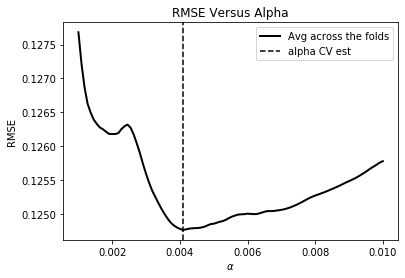

In [71]:
# Plot the average RMSE across each of the 5 test folds as alpha varies.

plotRMSEVersusAlpha(lassoMid.alphas_, lassoMid.alpha_, lassoMid.mse_path_, -1)

In [23]:
selectedMidFeatures = ['GrLivArea', 'OverallQual', 'TotalBsmtSF', 'GarageCars', 'FullBath', 'KitchenQual_E', 
                       'GarageType_E', 'BsmtQual_E', 'ExterQual_E', 'MSSubClass_E', 'GarageFinish_E', 
                       'Neighborhood_E', 'YearRemodAdd', 'Exterior1st_E', 'BsmtExposure_E', 'FireplaceQu_E', 
                       'Foundation_E', 'MasVnrType_E', 'BsmtFinSF1', 'MSZoning_E', 'LotFrontage', 'OpenPorchSF', 
                       '2ndFlrSF', 'GarageCond_E', 'HeatingQC_E', 'HouseStyle_E']

In [69]:
X_train_Mid2, X_test_Mid2, y_train_Mid2, y_test_Mid2, X_train_Mid_scaled2, X_test_Mid_scaled2 = checkRanksofFeatureMatrices(
    trainMid, selectedMidFeatures, trainMid['SalePrice'].values, 0.25, myStandardScaler, -2, 3)

(289, 26)
26
(97, 26)
26


          features  coefficients
0        GrLivArea      0.129298
1      OverallQual      0.085815
2      TotalBsmtSF      0.051547
23    GarageCond_E      0.050935
18      BsmtFinSF1      0.045207
19      MSZoning_E      0.034638
12    YearRemodAdd      0.029955
11  Neighborhood_E      0.028704
22        2ndFlrSF      0.028199
3       GarageCars      0.027008
24     HeatingQC_E      0.018465
14  BsmtExposure_E      0.016353
15   FireplaceQu_E      0.016198
9     MSSubClass_E      0.006673
5    KitchenQual_E      0.003085
20     LotFrontage      0.002677
7       BsmtQual_E      0.000784
13   Exterior1st_E      0.000230
17    MasVnrType_E     -0.000000
16    Foundation_E      0.000000
10  GarageFinish_E     -0.000000
21     OpenPorchSF      0.000000
8      ExterQual_E      0.000000
6     GarageType_E      0.000000
4         FullBath     -0.000138
25    HouseStyle_E     -0.018101
Train Error:  0.1046113555101258
Test Error:  0.1154862323219402


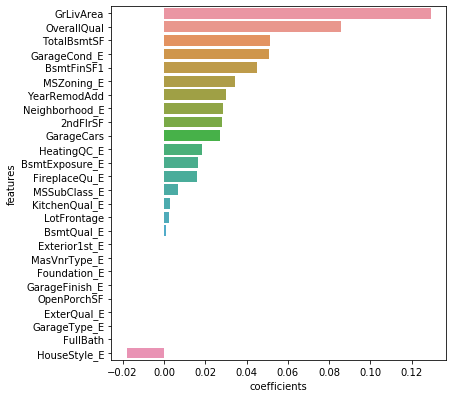

In [70]:
# Lasso with Standard Scaling on Mid Houses and selected features

# Train Error:  0.1046113555101258
# Test Error:  0.1154862323219402

midAlphas2 = np.linspace(0.001, 0.01, num=100)
lassoMid2 = myLassoCV(X_train_Mid_scaled2, y_train_Mid2, X_test_Mid_scaled2, y_test_Mid2, midAlphas2, selectedMidFeatures)

In [72]:
# We have a tendency to underestimate. Maybe we are winsorizing too aggressively

test_df_Mid = difficultExamples(X_test_Mid1, y_test_Mid1, lassoMid, X_test_Mid_scaled1)
test_df_Mid.head()

Test Error:  0.08827222994218709
Percent Overestimate:  0.17525773195876287


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,MSSubClass_E,MSZoning_E,Street_E,Alley_E,LotShape_E,LandContour_E,...,Neighborhood_E,Condition1_E,Condition2_E,BldgType_E,HouseStyle_E,RoofStyle_E,RoofMatl_E,Exterior1st_E,Exterior2nd_E,MasVnrType_E,ExterQual_E,ExterCond_E,Foundation_E,BsmtQual_E,BsmtCond_E,BsmtExposure_E,BsmtFinType1_E,BsmtFinType2_E,Heating_E,HeatingQC_E,CentralAir_E,Electrical_E,KitchenQual_E,Functional_E,FireplaceQu_E,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,MoSold_E,SaleType_E,SaleCondition_E,Predicted,Actual,OverEstimate,Error
284,80.0,14000,7,5,1996,1997,0.0,1201,0,105,1306,1306,954,0,2260,1,0,2,1,3,1,7,0,1996.0,2,533,296,44,0,0,0,0,0,2010,14,3,1,3,1,2,...,5,7,4,5,8,1,3,4,5,1,3,4,4,5,4,5,7,4,3,4,2,3,3,5,2,6,3,5,5,3,1,5,2,10,3,4,254426.954233,328000,0,0.064516
146,69.0,11423,8,5,2001,2002,479.0,1358,0,223,1581,1601,0,0,1601,1,0,2,0,3,1,6,1,2001.0,2,670,180,0,0,0,0,0,2000,2010,13,3,1,3,1,2,...,4,7,4,5,5,1,3,8,10,3,3,4,4,4,4,3,7,4,3,4,2,3,3,5,5,6,3,5,5,3,1,2,1,7,3,4,221005.731924,272000,0,0.043103
343,100.0,17500,7,8,1959,2002,0.0,1406,0,496,1902,1902,0,0,1902,1,0,2,0,3,1,7,2,1959.0,2,567,0,207,162,0,0,0,0,2010,13,3,1,3,1,2,...,6,9,4,5,5,1,3,9,6,1,3,3,4,4,4,3,7,4,3,1,2,3,4,5,5,6,4,5,5,3,1,5,2,7,3,4,273906.266201,335000,0,0.040540
141,69.0,32668,6,3,1957,1975,0.0,1219,0,816,2035,2515,0,0,2515,1,0,3,0,4,2,9,2,1975.0,2,484,0,0,200,0,0,0,0,2007,13,3,1,3,2,2,...,6,7,4,5,5,4,3,4,9,1,3,4,4,3,4,2,6,4,3,1,2,3,2,6,5,6,3,5,5,3,1,5,2,9,3,1,240471.357414,200624,1,0.032822
297,98.0,8731,5,5,1920,1950,0.0,645,0,270,915,1167,0,0,1167,0,0,1,0,3,1,6,1,1972.0,2,495,0,0,216,0,126,0,0,2007,1,3,1,3,2,2,...,1,7,4,5,5,1,3,6,8,1,2,2,2,3,4,2,4,4,3,1,2,3,2,6,4,3,2,5,5,3,1,5,2,7,3,4,120230.611076,144000,0,0.032545


In [73]:
X_train_Mid3, X_test_Mid3, y_train_Mid3, y_test_Mid3, X_train_Mid_scaled3, X_test_Mid_scaled3 = checkRanksofFeatureMatrices(
    trainMid, quantandqualE, trainMid['SalePrice'].values, 0.25, myStandardScaler, -3, 4)

(289, 79)
77
(97, 79)
75


           features  coefficients
14        GrLivArea      0.130225
2       OverallQual      0.082613
10      TotalBsmtSF      0.041033
7        BsmtFinSF1      0.037223
3       OverallCond      0.030803
24       GarageCars      0.027882
45     Condition2_E      0.024038
66     Functional_E      0.022401
1           LotArea      0.021331
63     CentralAir_E      0.021029
35       MSZoning_E      0.020031
64     Electrical_E      0.016610
0       LotFrontage      0.015776
62      HeatingQC_E      0.015358
29        3SsnPorch      0.014258
56       BsmtQual_E      0.014080
78  SaleCondition_E      0.013164
22       Fireplaces      0.012983
5      YearRemodAdd      0.012077
71     GarageCond_E      0.011797
43   Neighborhood_E      0.011439
58   BsmtExposure_E      0.011248
70     GarageQual_E      0.010197
12         2ndFlrSF      0.009516
51    Exterior2nd_E      0.008843
19     BedroomAbvGr      0.008693
15     BsmtFullBath      0.008456
52     MasVnrType_E      0.007058
16     BsmtHal

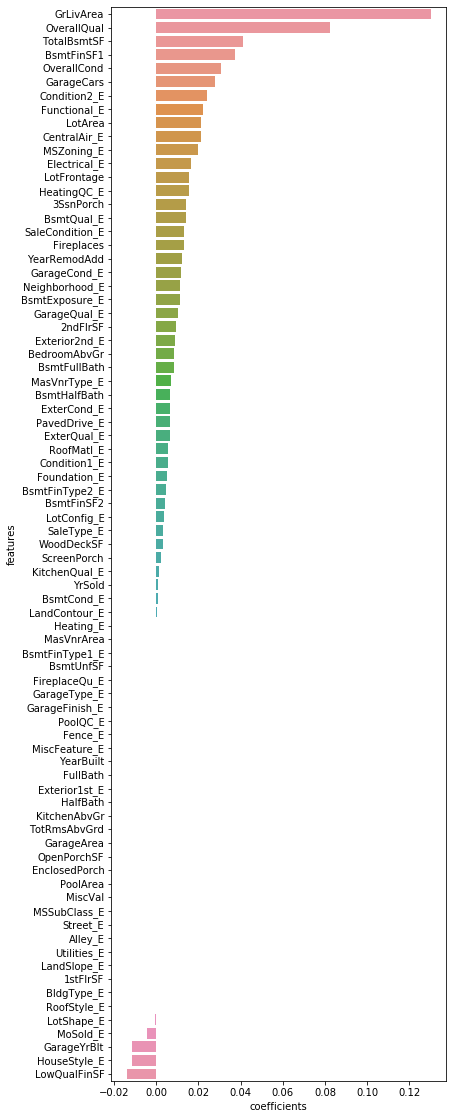

In [74]:
# Lasso with Standard Scaling on Mid Houses

# Train Error:  0.0972578709881729
# Test Error:  0.08827222994218707

# No overfitting, but I do wonder if playing around with the number of features can decrease test error more.

midAlphas3 = np.linspace(0.001, 0.01, num=100)
lassoMid3 = myLassoCV(X_train_Mid_scaled3, y_train_Mid3, X_test_Mid_scaled3, y_test_Mid3, midAlphas3, quantandqualE)

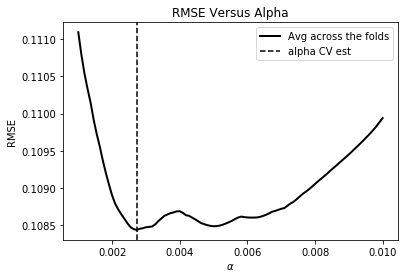

In [75]:
# Plot the average RMSE across each of the 5 test folds as alpha varies.

plotRMSEVersusAlpha(lassoMid3.alphas_, lassoMid3.alpha_, lassoMid3.mse_path_, -1)

In [76]:
# We have a tendency to underestimate. Maybe we are winsorizing too aggressively

test_df_Mid3 = difficultExamples(X_test_Mid3, y_test_Mid3, lassoMid3, X_test_Mid_scaled3)
test_df_Mid3.head()

Test Error:  0.10499456252634791
Percent Overestimate:  0.5051546391752577


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,MSSubClass_E,MSZoning_E,Street_E,Alley_E,LotShape_E,LandContour_E,...,Neighborhood_E,Condition1_E,Condition2_E,BldgType_E,HouseStyle_E,RoofStyle_E,RoofMatl_E,Exterior1st_E,Exterior2nd_E,MasVnrType_E,ExterQual_E,ExterCond_E,Foundation_E,BsmtQual_E,BsmtCond_E,BsmtExposure_E,BsmtFinType1_E,BsmtFinType2_E,Heating_E,HeatingQC_E,CentralAir_E,Electrical_E,KitchenQual_E,Functional_E,FireplaceQu_E,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,MoSold_E,SaleType_E,SaleCondition_E,Predicted,Actual,OverEstimate,Error
127,69.0,53227,4,6,1954,1994,0.0,1116,0,248,1364,1663,0,0,1663,1,0,1,0,2,1,6,2,1954.0,2,529,224,137,0,0,0,0,0,2008,13,3,1,3,2,3,...,5,7,4,5,5,2,2,7,7,1,2,4,3,4,4,5,4,4,3,4,2,3,3,2,4,6,4,5,5,3,1,5,2,9,3,4,183655.857158,256000,0,0.110300
141,69.0,32668,6,3,1957,1975,0.0,1219,0,816,2035,2515,0,0,2515,1,0,3,0,4,2,9,2,1975.0,2,484,0,0,200,0,0,0,0,2007,13,3,1,3,2,2,...,6,7,4,5,5,4,3,4,9,1,3,4,4,3,4,2,6,4,3,1,2,3,2,6,5,6,3,5,5,3,1,5,2,9,3,1,259234.486559,200624,1,0.065690
125,62.0,70761,7,5,1975,1975,0.0,655,0,878,1533,1533,0,0,1533,1,0,2,0,2,1,5,2,1975.0,2,576,200,54,0,0,0,0,0,2006,13,3,1,3,2,3,...,5,7,4,5,5,1,6,7,7,1,2,4,3,4,4,5,3,4,3,1,2,3,3,5,5,6,2,5,5,3,1,5,2,12,3,4,216776.969035,280000,0,0.065495
245,52.0,5825,4,5,1926,1953,108.0,0,0,600,600,747,0,0,747,0,0,1,0,1,1,5,0,1953.0,2,528,0,0,32,0,0,0,0,2006,1,3,1,3,2,2,...,1,7,4,5,5,1,3,3,3,3,2,3,4,2,4,4,5,4,3,3,2,3,2,5,2,3,2,5,5,3,1,5,2,6,3,4,100811.803207,79900,1,0.054047
93,69.0,11888,6,6,1916,1994,0.0,0,0,844,844,1445,689,0,2134,0,0,2,0,5,1,10,0,1930.0,2,441,0,60,268,0,0,0,0,2009,11,3,1,2,2,1,...,1,8,4,5,6,1,3,4,2,1,2,4,2,3,4,2,5,4,3,3,1,2,3,5,2,3,2,5,5,3,1,5,2,2,3,4,171800.560182,214500,0,0.049273


In [78]:
X_train_Cheap1, X_test_Cheap1, y_train_Cheap1, y_test_Cheap1, X_train_Cheap_scaled1, X_test_Cheap_scaled1 = checkRanksofFeatureMatrices(
    trainCheap, quantandqualE, trainCheap['SalePrice'].values, 0.25, myStandardScaler, -2, 3)

(612, 79)
78
(205, 79)
77


           features  coefficients
14        GrLivArea      0.102926
3       OverallCond      0.058584
2       OverallQual      0.058183
10      TotalBsmtSF      0.037800
63     CentralAir_E      0.033260
24       GarageCars      0.023885
22       Fireplaces      0.022103
23      GarageYrBlt      0.022017
34     MSSubClass_E      0.020374
35       MSZoning_E      0.020272
43   Neighborhood_E      0.018924
78  SaleCondition_E      0.017983
1           LotArea      0.014290
69   GarageFinish_E      0.011594
41      LotConfig_E      0.011126
4         YearBuilt      0.011070
59   BsmtFinType1_E      0.009824
26       WoodDeckSF      0.009462
55     Foundation_E      0.009430
71     GarageCond_E      0.008753
7        BsmtFinSF1      0.008580
65    KitchenQual_E      0.008345
30      ScreenPorch      0.007440
15     BsmtFullBath      0.007137
62      HeatingQC_E      0.005161
5      YearRemodAdd      0.004852
66     Functional_E      0.004751
68     GarageType_E      0.004645
50    Exterior

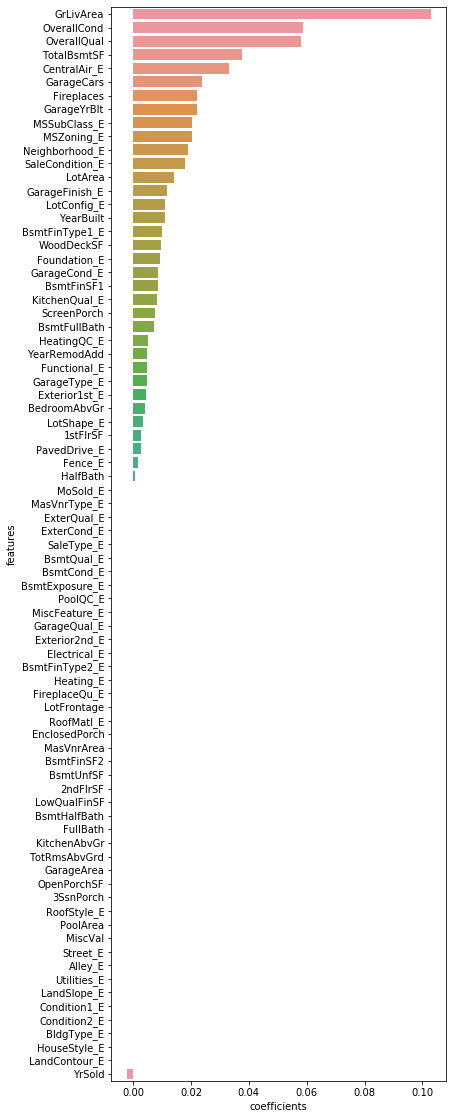

In [82]:
# Lasso with Standard Scaling on Cheap Houses

# Train Error:  0.1272939609411646
# Test Error:  0.13152475291664578

cheapAlphas = np.linspace(0.001, 0.01, num=100)
lassoCheap = myLassoCV(X_train_Cheap_scaled1, y_train_Cheap1, X_test_Cheap_scaled1, y_test_Cheap1, cheapAlphas, quantandqualE)

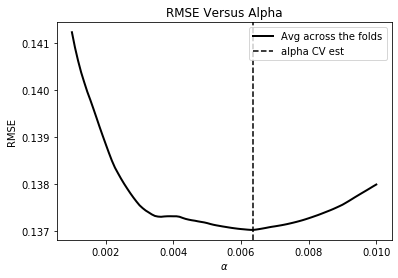

In [83]:
# Plot the average RMSE across each of the 5 test folds as alpha varies.

plotRMSEVersusAlpha(lassoCheap.alphas_, lassoCheap.alpha_, lassoCheap.mse_path_, -1)

In [84]:
# We are really overestimating the outlier at the top.

test_df_Cheap = difficultExamples(X_test_Cheap1, y_test_Cheap1, lassoCheap, X_test_Cheap_scaled1)
test_df_Cheap.head()

Test Error:  0.13152475291664573
Percent Overestimate:  0.48292682926829267


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,MSSubClass_E,MSZoning_E,Street_E,Alley_E,LotShape_E,LandContour_E,...,Neighborhood_E,Condition1_E,Condition2_E,BldgType_E,HouseStyle_E,RoofStyle_E,RoofMatl_E,Exterior1st_E,Exterior2nd_E,MasVnrType_E,ExterQual_E,ExterCond_E,Foundation_E,BsmtQual_E,BsmtCond_E,BsmtExposure_E,BsmtFinType1_E,BsmtFinType2_E,Heating_E,HeatingQC_E,CentralAir_E,Electrical_E,KitchenQual_E,Functional_E,FireplaceQu_E,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,MoSold_E,SaleType_E,SaleCondition_E,Predicted,Actual,OverEstimate,Error
728,313.0,63887,10,5,2008,2008,796.0,5644,0,466,6110,4692,950,0,5642,2,0,2,1,3,1,12,3,2008.0,2,1418,214,292,0,0,0,480,0,2008,15,4,2,2,4,1,...,5,3,5,5,7,3,3,7,5,4,4,2,6,5,4,5,7,3,5,5,2,5,4,7,4,5,4,5,5,3,2,4,2,1,8,6,379009.333771,160000,1,0.743711
534,60.0,10800,4,4,1949,1950,0.0,0,0,720,720,720,472,0,1192,0,0,1,1,4,1,6,0,1949.0,0,0,0,0,0,0,0,0,0,2006,5,4,2,2,1,3,...,8,4,5,5,2,2,2,4,3,1,2,2,4,3,4,2,2,3,5,3,1,4,2,7,1,1,1,1,1,3,1,4,2,6,6,2,82773.879583,135000,0,0.239280
799,60.0,10800,4,6,1927,2007,0.0,0,0,656,656,968,0,0,968,0,0,2,0,4,1,5,0,1928.0,1,216,0,0,0,0,0,0,0,2007,2,4,2,1,1,3,...,4,4,5,5,5,2,2,9,9,1,2,2,3,3,4,2,2,3,5,3,2,5,2,7,1,3,2,3,2,3,1,4,2,4,6,4,95851.272034,64500,1,0.156921
404,60.0,10800,5,5,1987,1988,0.0,1200,0,0,1200,1200,0,0,1200,3,0,3,0,3,1,5,0,1987.0,0,0,120,0,0,0,0,0,0,2009,7,4,2,2,1,3,...,5,4,5,4,5,2,2,12,14,1,2,2,4,4,5,5,7,3,5,3,2,5,2,7,1,1,1,1,1,3,1,4,2,9,6,5,125141.495675,179000,0,0.128122
389,69.0,13517,6,8,1976,2005,289.0,533,0,192,725,725,754,0,1479,0,0,2,1,3,1,6,0,1976.0,2,475,0,44,0,0,0,0,0,2010,15,4,2,2,2,3,...,6,2,5,5,7,2,2,11,14,3,3,2,4,3,4,2,7,3,5,5,2,5,3,7,1,5,3,5,5,3,1,4,2,9,6,4,183057.835604,130500,1,0.114534


In [85]:
test_df_Cheap_scaled = difficultExamplesScaled(X_test_Cheap_scaled1, y_test_Cheap1, lassoCheap, quantandqualE)
test_df_Cheap_scaled.head()

Test Error:  0.13152475291664573
Percent Overestimate:  0.48292682926829267


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,MSSubClass_E,MSZoning_E,Street_E,Alley_E,LotShape_E,LandContour_E,...,Neighborhood_E,Condition1_E,Condition2_E,BldgType_E,HouseStyle_E,RoofStyle_E,RoofMatl_E,Exterior1st_E,Exterior2nd_E,MasVnrType_E,ExterQual_E,ExterCond_E,Foundation_E,BsmtQual_E,BsmtCond_E,BsmtExposure_E,BsmtFinType1_E,BsmtFinType2_E,Heating_E,HeatingQC_E,CentralAir_E,Electrical_E,KitchenQual_E,Functional_E,FireplaceQu_E,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,MoSold_E,SaleType_E,SaleCondition_E,Predicted,Actual,OverEstimate,Error
4,3.000000,3.000000,3.000000,-0.597533,1.802066,1.431090,3.000000,3.000000,-0.322236,-0.132270,3.000000,3.000000,1.868218,-0.148226,3.000000,3.00000,-0.260208,1.181920,1.469388,0.124472,-0.218089,3.000000,3.000000,1.698257,0.721824,3.000000,1.199086,3.000000,-0.392469,0.0,-0.245044,3.000000,-0.174427,0.021850,1.571914,0.488587,0.070014,0.133697,3.000000,-2.000000,...,-0.739535,-0.862777,0.070014,0.351630,1.285778,1.438160,2.191786,-1.357792,-1.636252,2.369973,3.000000,-0.31675,1.699307,2.813396,0.143247,2.553517,1.484588,-0.274632,0.097312,1.301005,0.260208,0.290957,3.000000,0.263377,0.935542,0.687452,1.804510,0.399776,0.375378,0.310843,3.000000,0.456166,-0.205847,-1.840941,2.657646,2.739272,379009.333771,160000,1,0.743711
94,-0.372909,0.147495,-1.461474,-1.377751,-0.420654,-1.430128,-0.519954,-0.832299,-0.322236,0.529908,-0.550832,-0.888267,0.566577,-0.148226,-0.332005,-0.70568,-0.260208,-0.725903,1.469388,1.339555,-0.218089,-0.168732,-0.767373,-0.718547,-2.000000,-1.896493,-0.581984,-0.532562,-0.392469,0.0,-0.245044,-0.099206,-0.174427,-1.471242,-1.024721,0.488587,0.070014,0.133697,-0.535014,0.168606,...,0.315718,0.229009,0.070014,0.351630,-1.928667,-0.514309,-0.160654,-2.000000,-2.000000,-0.666555,-0.291256,-0.31675,-0.252278,-0.373047,0.143247,-0.489919,-1.130021,-0.274632,0.097312,-0.885110,-2.000000,-2.000000,-0.465736,0.263377,-0.797465,-2.000000,-1.652729,-2.000000,-2.000000,0.310843,-0.088692,0.456166,-0.205847,-0.370197,0.069440,-2.000000,82773.879583,135000,0,0.239280
44,-0.372909,0.147495,-1.461474,0.182685,-1.249464,1.381759,-0.519954,-0.832299,-0.322236,0.363060,-0.679891,-0.297081,-0.718725,-0.148226,-0.760207,-0.70568,-0.260208,1.181920,-0.622449,1.339555,-0.218089,-0.889358,-0.767373,-1.578766,-0.687452,-0.889711,-0.581984,-0.532562,-0.392469,0.0,-0.245044,-0.099206,-0.174427,-0.724696,-1.803711,0.488587,0.070014,-2.000000,-0.535014,0.168606,...,-1.091286,0.229009,0.070014,0.351630,0.000000,-0.514309,-0.160654,-0.483860,-0.476592,-0.666555,-0.291256,-0.31675,-1.228070,-0.373047,0.143247,-0.489919,-1.130021,-0.274632,0.097312,-0.885110,0.260208,0.290957,-0.465736,0.263377,-0.797465,-0.721824,-0.500316,-1.239306,-2.000000,0.310843,-0.088692,0.456166,-0.205847,-0.958495,0.069440,0.198318,95851.272034,64500,1,0.156921
107,-0.372909,0.147495,-0.485571,-0.597533,1.010928,0.444463,-0.519954,1.480844,-0.322236,-1.347133,0.417110,0.255963,-0.718725,-0.148226,-0.316712,3.00000,-0.260208,3.000000,-0.622449,0.124472,-0.218089,-0.889358,-0.767373,0.838039,-2.000000,-1.896493,0.416747,-0.532562,-0.392469,0.0,-0.245044,-0.099206,-0.174427,0.768396,-0.505394,0.488587,0.070014,0.133697,-0.535014,0.168606,...,-0.739535,0.229009,0.070014,-0.724252,0.000000,-0.514309,-0.160654,0.827038,0.972983,-0.666555,-0.291256,-0.31675,-0.252278,1.220174,2.402140,2.553517,1.484588,-0.274632,0.097312,-0.885110,0.260208,0.290957,-0.465736,0.263377,-0.797465,-2.000000,-1.652729,-2.000000,-2.000000,0.310843,-0.088692,0.456166,-0.205847,0.512249,0.069440,1.468795,125141.495675,179000,0,0.128122
101,-0.084915,0.616977,0.490332,1.

In [86]:
# We over-estimated the price because the sample is an outlier. 
# Maybe we should have more aggressive winsorizing for cheap houses.

understand_0_Cheap = understandCoefficients(quantandqualE, lassoCheap, test_df_Cheap_scaled, test_df_Cheap, 0)
understand_0_Cheap.head(n=100)

,features,model coeffs,scaled values,actual values,Weight
14,GrLivArea,0.102926,3.000000,5642.0,0.308777
2,OverallQual,0.058183,3.000000,10.0,0.174548
10,TotalBsmtSF,0.037800,3.000000,6110.0,0.113401
22,Fireplaces,0.022103,3.000000,3.0,0.066310
78,SaleCondition_E,0.017983,2.739272,6.0,0.049261
1,LotArea,0.014290,3.000000,63887.0,0.042869
23,GarageYrBlt,0.022017,1.698257,2008.0,0.037391
34,MSSubClass_E,0.020374,1.571914,15.0,0.032026
7,BsmtFinSF1,0.008580,3.000000,5644.0,0.025739
65,KitchenQual_E,0.008345,3.000000,4.0,0.025034


In [87]:
X_train_Cheap2, X_test_Cheap2, y_train_Cheap2, y_test_Cheap2, X_train_Cheap_scaled2, X_test_Cheap_scaled2 = checkRanksofFeatureMatrices(
    trainCheap, quantandqualE, trainCheap['SalePrice'].values, 0.25, myStandardScaler, -3, 2)

(612, 79)
78
(205, 79)
77


           features  coefficients
14        GrLivArea      0.108356
3       OverallCond      0.053570
2       OverallQual      0.050508
10      TotalBsmtSF      0.041148
35       MSZoning_E      0.028469
22       Fireplaces      0.023473
24       GarageCars      0.023255
1           LotArea      0.021872
34     MSSubClass_E      0.020817
63     CentralAir_E      0.020280
66     Functional_E      0.019197
78  SaleCondition_E      0.015863
23      GarageYrBlt      0.013158
17         FullBath      0.012775
62      HeatingQC_E      0.012719
4         YearBuilt      0.012562
43   Neighborhood_E      0.012422
15     BsmtFullBath      0.012070
71     GarageCond_E      0.011940
7        BsmtFinSF1      0.011280
59   BsmtFinType1_E      0.011101
30      ScreenPorch      0.010210
26       WoodDeckSF      0.009720
11         1stFlrSF      0.008644
5      YearRemodAdd      0.008623
18         HalfBath      0.008610
74          Fence_E      0.008486
65    KitchenQual_E      0.008330
39    LandCont

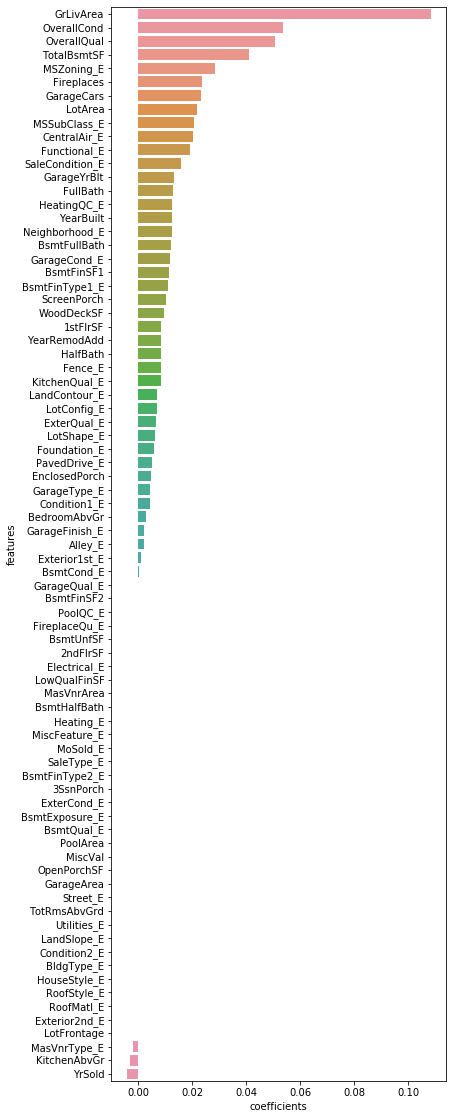

In [88]:
# Lasso with Standard Scaling on Cheap Houses and more aggressive winsorizing

# Train Error:  0.1281054389347719
# Test Error:  0.11155850124310893

cheapAlphas2 = np.linspace(0.001, 0.01, num=100)
lassoCheap2 = myLassoCV(X_train_Cheap_scaled2, y_train_Cheap2, X_test_Cheap_scaled2, y_test_Cheap2, cheapAlphas2, quantandqualE)

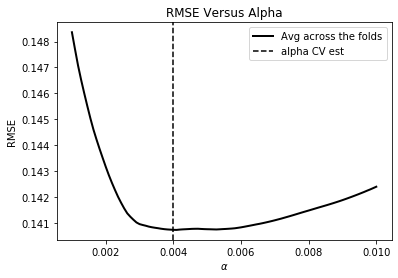

In [89]:
# Plot the average RMSE across each of the 5 test folds as alpha varies.

plotRMSEVersusAlpha(lassoCheap2.alphas_, lassoCheap2.alpha_, lassoCheap2.mse_path_, -1)

In [90]:
# We are really overestimating the outlier at the top.

test_df_Cheap2 = difficultExamples(X_test_Cheap2, y_test_Cheap2, lassoCheap2, X_test_Cheap_scaled2)
test_df_Cheap2.head()

Test Error:  0.11155850124310898
Percent Overestimate:  0.47317073170731705


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,MSSubClass_E,MSZoning_E,Street_E,Alley_E,LotShape_E,LandContour_E,...,Neighborhood_E,Condition1_E,Condition2_E,BldgType_E,HouseStyle_E,RoofStyle_E,RoofMatl_E,Exterior1st_E,Exterior2nd_E,MasVnrType_E,ExterQual_E,ExterCond_E,Foundation_E,BsmtQual_E,BsmtCond_E,BsmtExposure_E,BsmtFinType1_E,BsmtFinType2_E,Heating_E,HeatingQC_E,CentralAir_E,Electrical_E,KitchenQual_E,Functional_E,FireplaceQu_E,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,MoSold_E,SaleType_E,SaleCondition_E,Predicted,Actual,OverEstimate,Error
389,69.0,13517,6,8,1976,2005,289.0,533,0,192,725,725,754,0,1479,0,0,2,1,3,1,6,0,1976.0,2,475,0,44,0,0,0,0,0,2010,15,4,2,2,2,3,...,6,2,5,5,7,2,2,11,14,3,3,2,4,3,4,2,7,3,5,5,2,5,3,7,1,5,3,5,5,3,1,4,2,9,6,4,191389.436747,130500,1,0.146641
478,52.0,5720,5,6,1941,1950,0.0,0,0,676,676,676,455,0,1131,0,0,1,1,3,1,5,0,1941.0,1,200,26,0,0,0,0,0,0,2009,5,2,2,2,1,3,...,4,1,5,5,2,2,2,9,9,1,2,2,4,3,4,2,2,3,5,5,2,5,2,7,1,3,2,5,5,3,1,4,2,4,6,2,95128.264115,66500,1,0.128181
324,75.0,13500,10,9,1893,2000,0.0,0,0,1237,1237,1521,1254,0,2775,0,0,3,1,3,1,9,1,1988.0,2,880,105,502,0,0,0,0,0,2008,13,2,2,2,1,3,...,4,1,8,5,3,2,2,9,9,1,4,4,3,3,4,2,2,3,5,4,2,5,3,7,4,3,2,6,5,3,1,4,2,11,6,4,231829.120474,325000,0,0.114125
345,70.0,11606,5,5,1969,1969,192.0,650,0,390,1040,1040,1040,0,2080,0,1,1,2,5,1,9,2,1969.0,2,504,335,0,0,0,0,0,0,2007,15,4,2,2,2,4,...,8,4,5,5,7,2,2,12,14,3,2,2,6,4,4,4,5,3,5,3,2,5,1,7,5,5,2,5,5,3,1,4,2,2,6,3,187803.195180,135000,1,0.108979
81,71.0,8520,5,4,1952,1952,0.0,507,0,403,910,910,475,0,1385,0,0,2,0,4,1,6,0,2000.0,2,720,0,0,0,0,0,0,0,2010,5,4,2,2,1,3,...,8,1,5,5,2,2,2,10,9,1,2,1,4,3,4,2,5,3,5,2,2,5,2,7,1,3,2,5,5,3,1,3,2,10,6,4,121285.961644,166000,0,0.098493


In [92]:
X_train_Exp_scaled_final, X_test_Exp_scaled_final = checkRanksofFeatureMatricesNoSplit(
    trainExp, testExp, selectedExpFeatures, myStandardScaler, -3, 4)

(257, 17)
17
(265, 17)
17


          features  coefficients
0        GrLivArea      0.113716
1      OverallQual      0.062951
7       BsmtFinSF1      0.056597
2          LotArea      0.048586
5    KitchenQual_E      0.030752
8     MSSubClass_E      0.029673
13  BsmtExposure_E      0.026472
4       BsmtQual_E      0.024276
3       GarageCars      0.013941
6      LotFrontage      0.013821
14  GarageFinish_E      0.009213
11     RoofStyle_E      0.008550
9      ExterQual_E      0.007997
12  Neighborhood_E      0.005681
10      MasVnrArea      0.004777
15      MSZoning_E      0.000000
16    GarageType_E      0.000000
Train Error:  0.10938764307281812


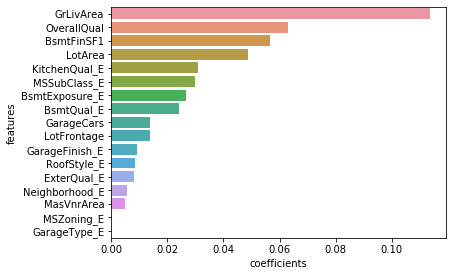

In [93]:
ExpAlphasFinal = np.linspace(0.0001, 0.005, num=100)
lassoExpFinal = myLassoCVFinal(X_train_Exp_scaled_final, trainExp['SalePrice'], ExpAlphasFinal, selectedExpFeatures)

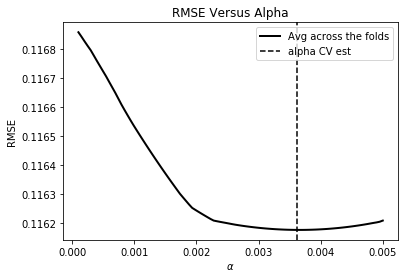

In [95]:
# Plot the average RMSE across each of the 5 test folds as alpha varies.

plotRMSEVersusAlpha(lassoExpFinal.alphas_, lassoExpFinal.alpha_, lassoExpFinal.mse_path_, -1)

In [94]:
X_train_Mid_scaled_final, X_test_Mid_scaled_final = checkRanksofFeatureMatricesNoSplit(
    trainMid, testMid, quantandqualE, myStandardScaler, -2, 3)

(386, 79)
77
(343, 79)
76


           features  coefficients
14        GrLivArea      0.133703
2       OverallQual      0.082923
10      TotalBsmtSF      0.043158
3       OverallCond      0.036760
1           LotArea      0.035610
7        BsmtFinSF1      0.030478
63     CentralAir_E      0.029397
24       GarageCars      0.024668
43   Neighborhood_E      0.020091
56       BsmtQual_E      0.019995
35       MSZoning_E      0.018893
71     GarageCond_E      0.017930
72     PavedDrive_E      0.017903
70     GarageQual_E      0.016622
78  SaleCondition_E      0.014693
62      HeatingQC_E      0.013764
58   BsmtExposure_E      0.013536
50    Exterior1st_E      0.012853
12         2ndFlrSF      0.012366
5      YearRemodAdd      0.012172
22       Fireplaces      0.011776
29        3SsnPorch      0.010307
15     BsmtFullBath      0.010268
65    KitchenQual_E      0.009407
0       LotFrontage      0.009101
57       BsmtCond_E      0.008684
41      LotConfig_E      0.007764
44     Condition1_E      0.007056
16     BsmtHal

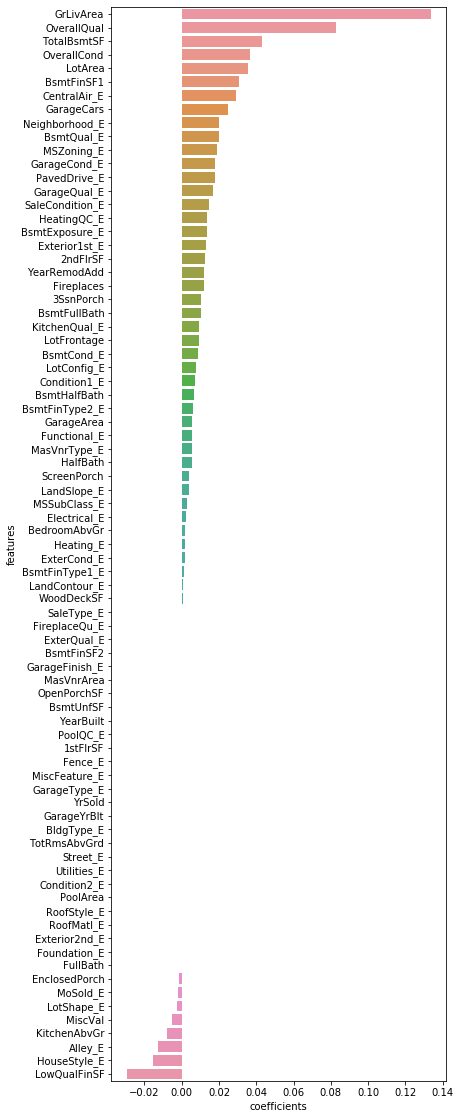

In [106]:
MidAlphasFinal = np.linspace(0.002, 0.005, num=100)
lassoMidFinal = myLassoCVFinal(X_train_Mid_scaled_final, trainMid['SalePrice'], MidAlphasFinal, quantandqualE)

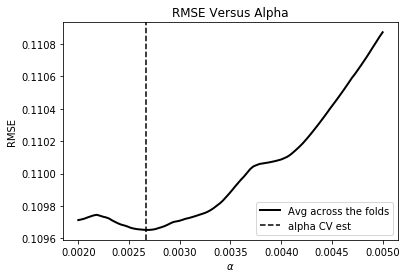

In [107]:
# Plot the average RMSE across each of the 5 test folds as alpha varies.

plotRMSEVersusAlpha(lassoMidFinal.alphas_, lassoMidFinal.alpha_, lassoMidFinal.mse_path_, -1)

In [108]:
X_train_Cheap_scaled_final, X_test_Cheap_scaled_final = checkRanksofFeatureMatricesNoSplit(
    trainCheap, testCheap, quantandqualE, myStandardScaler, -3, 2)

(817, 79)
78
(851, 79)
77


           features  coefficients
14        GrLivArea      0.101759
3       OverallCond      0.055316
2       OverallQual      0.050233
10      TotalBsmtSF      0.035237
66     Functional_E      0.024758
35       MSZoning_E      0.024007
78  SaleCondition_E      0.021627
24       GarageCars      0.020153
22       Fireplaces      0.020031
11         1stFlrSF      0.019918
34     MSSubClass_E      0.019610
1           LotArea      0.019358
17         FullBath      0.017753
30      ScreenPorch      0.017381
63     CentralAir_E      0.016143
7        BsmtFinSF1      0.016091
23      GarageYrBlt      0.015537
15     BsmtFullBath      0.013486
71     GarageCond_E      0.012245
43   Neighborhood_E      0.011701
26       WoodDeckSF      0.011384
41      LotConfig_E      0.011270
4         YearBuilt      0.010785
62      HeatingQC_E      0.010192
5      YearRemodAdd      0.010014
39    LandContour_E      0.009587
55     Foundation_E      0.009463
18         HalfBath      0.009418
59   BsmtFinTy

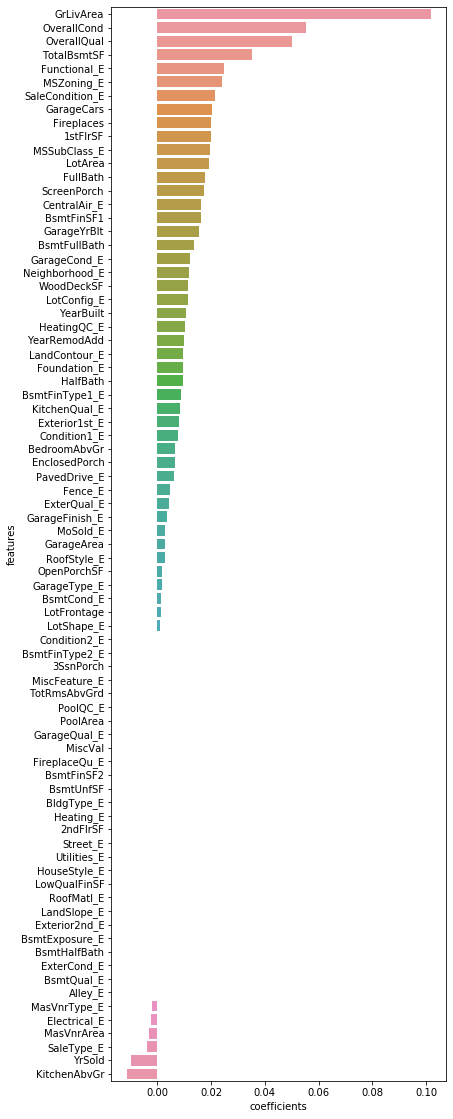

In [111]:
CheapAlphasFinal = np.linspace(0.001, 0.005, num=100)
lassoCheapFinal = myLassoCVFinal(X_train_Cheap_scaled_final, trainCheap['SalePrice'], CheapAlphasFinal, quantandqualE)

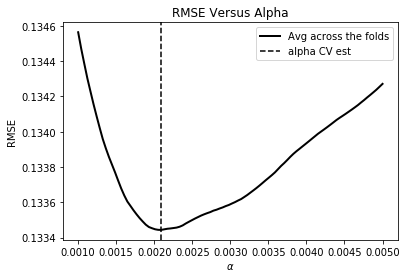

In [112]:
# Plot the average RMSE across each of the 5 test folds as alpha varies.

plotRMSEVersusAlpha(lassoCheapFinal.alphas_, lassoCheapFinal.alpha_, lassoCheapFinal.mse_path_, -1)

In [113]:
testExpFinal = testExp.copy()
modelPredict(X_test_Exp_scaled_final, lassoExpFinal, testExpFinal, 'lassoExp', True)
testExpFinal.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Utilities_E,LotConfig_E,LandSlope_E,Neighborhood_E,Condition1_E,Condition2_E,BldgType_E,HouseStyle_E,RoofStyle_E,RoofMatl_E,Exterior1st_E,Exterior2nd_E,MasVnrType_E,ExterQual_E,ExterCond_E,Foundation_E,BsmtQual_E,BsmtCond_E,BsmtExposure_E,BsmtFinType1_E,BsmtFinType2_E,Heating_E,HeatingQC_E,CentralAir_E,Electrical_E,KitchenQual_E,Functional_E,FireplaceQu_E,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,MoSold_E,SaleType_E,SaleCondition_E,SalePrice
0,1465,SC120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,...,1,3,1,4,2,1,2,2,1,1,3,4,1,2,1,2,1,1,1,2,4,1,3,1,1,2,2,1,2,2,1,1,1,1,2,1,12,4,1,187075.347780
1,1476,SC60,RL,102.0,12858,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,2Story,9,5,2009,2010,Gable,CompShg,VinylSd,VinylSd,Stone,162.0,Ex,TA,PConc,Ex,TA,No,Unf,0.0,Unf,0.0,1590.0,1590.0,GasA,...,1,3,1,6,2,1,3,3,1,1,4,5,2,3,1,2,3,1,1,4,4,1,3,1,1,3,2,4,2,3,1,1,1,1,2,1,12,6,3,346711.628648
2,1477,SC20,RL,94.0,12883,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NridgHt,Norm,Norm,1Fam,1Story,8,5,2009,2010,Gable,CompShg,VinylSd,VinylSd,Stone,256.0,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,1544.0,1544.0,GasA,...,1,5,1,6,2,1,3,2,1,1,4,5,2,2,1,2,1,1,1,4,4,1,3,1,1,2,2,1,2,2,1,1,1,1,2,1,2,6,3,228790.798668
3,1478,SC20,RL,90.0,11520,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,PosN,Norm,1Fam,1Story,9,5,2005,2005,Hip,CompShg,VinylSd,VinylSd,BrkFace,615.0,Gd,TA,PConc,Ex,TA,No,GLQ,110.0,Unf,0.0,1588.0,1698.0,GasA,...,1,3,1,6,5,1,3,2,2,1,4,5,3,2,1,2,3,1,1,5,4,1,3,1,1,3,2,4,2,3,1,1,1,1,2,1,2,4,1,292543.754001
4,1479,SC20,RL,79.0,14122,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,8,5,2005,2006,Hip,CompShg,CemntBd,CmentBd,BrkFace,240.0,Gd,TA,PConc,Ex,TA,No,GLQ,28.0,Unf,0.0,1794.0,1822.0,GasA,...,1,3,1,6,2,1,3,2,2,1,7,6,3,2,1,2,3,1,1,5,4,1,3,1,1,3,2,4,2,2,1,1,1,1,2,1,1,4,1,278954.611276


In [115]:
testMidFinal = testMid.copy()
modelPredict(X_test_Mid_scaled_final, lassoMidFinal, testMidFinal, 'lassoMid', True)
testMidFinal.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Utilities_E,LotConfig_E,LandSlope_E,Neighborhood_E,Condition1_E,Condition2_E,BldgType_E,HouseStyle_E,RoofStyle_E,RoofMatl_E,Exterior1st_E,Exterior2nd_E,MasVnrType_E,ExterQual_E,ExterCond_E,Foundation_E,BsmtQual_E,BsmtCond_E,BsmtExposure_E,BsmtFinType1_E,BsmtFinType2_E,Heating_E,HeatingQC_E,CentralAir_E,Electrical_E,KitchenQual_E,Functional_E,FireplaceQu_E,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,MoSold_E,SaleType_E,SaleCondition_E,SalePrice
0,1491,SC60,RL,70.0,11920,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,2004,2004,Gable,CompShg,VinylSd,VinylSd,BrkFace,122.0,Gd,TA,PConc,Gd,TA,Av,Unf,0.0,Unf,0.0,831.0,831.0,GasA,...,2,4,1,3,7,4,5,8,1,3,8,10,3,3,4,4,4,4,3,5,4,3,4,2,3,3,5,2,6,3,5,5,3,1,5,2,10,3,4,194308.741937
1,1492,SC30,RH,70.0,9800,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,SawyerW,Feedr,Norm,1Fam,1Story,5,5,1920,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,Fa,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,816.0,816.0,GasA,...,2,3,1,3,4,4,5,5,1,3,4,5,1,2,2,2,3,4,2,5,4,3,1,1,2,2,5,2,3,2,5,5,3,1,5,2,10,3,4,92470.892486
2,1542,SC50,RM,53.0,5830,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Feedr,Feedr,1Fam,1.5Fin,5,6,1950,1997,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,Gd,CBlock,TA,TA,No,Rec,788.0,Unf,0.0,200.0,988.0,GasA,...,2,3,1,1,4,3,5,3,1,3,3,3,1,2,3,3,3,4,2,6,4,3,4,2,3,2,5,2,3,2,5,5,3,1,2,2,9,3,4,141792.442141
3,1543,SC75,RL,69.0,7793,Pave,None,IR1,Bnk,AllPub,Corner,Gtl,BrkSide,Norm,Norm,1Fam,2.5Unf,7,7,1922,2005,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,Gd,TA,No,BLQ,474.0,Unf,0.0,634.0,1108.0,GasA,...,2,3,1,1,7,4,5,6,1,3,4,5,1,2,4,2,4,4,2,4,4,3,1,1,2,3,5,4,3,2,5,5,3,1,5,2,7,3,4,203004.975595
4,1544,SC30,RM,50.0,5000,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1925,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,Rec,188.0,Unf,0.0,577.0,765.0,GasA,...,2,4,1,1,4,4,5,5,1,3,3,3,1,2,4,2,3,4,2,6,4,3,1,1,1,3,5,2,3,2,3,5,2,1,2,2,10,3,4,77285.040677


In [118]:
testCheapFinal = testCheap.copy()
modelPredict(X_test_Cheap_scaled_final, lassoCheapFinal, testCheapFinal, 'lassoCheap', True)
testCheapFinal.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Utilities_E,LotConfig_E,LandSlope_E,Neighborhood_E,Condition1_E,Condition2_E,BldgType_E,HouseStyle_E,RoofStyle_E,RoofMatl_E,Exterior1st_E,Exterior2nd_E,MasVnrType_E,ExterQual_E,ExterCond_E,Foundation_E,BsmtQual_E,BsmtCond_E,BsmtExposure_E,BsmtFinType1_E,BsmtFinType2_E,Heating_E,HeatingQC_E,CentralAir_E,Electrical_E,KitchenQual_E,Functional_E,FireplaceQu_E,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,MoSold_E,SaleType_E,SaleCondition_E,SalePrice
0,1461,SC20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,...,1,1,3,8,3,5,5,5,2,2,13,15,1,2,2,4,3,4,2,5,6,5,3,2,5,2,7,1,5,2,5,5,3,1,3,2,10,6,4,120053.096850
1,1462,SC20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,...,1,2,3,8,4,5,5,5,3,2,9,9,3,2,2,4,3,4,2,6,3,5,3,2,5,3,7,1,5,2,5,5,3,1,4,4,10,6,4,163555.479062
2,1463,SC60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,...,1,1,3,11,4,5,5,7,2,2,13,15,1,2,2,6,4,4,2,7,3,5,4,2,5,2,7,5,5,4,5,5,3,1,3,2,9,6,4,182342.930470
3,1464,SC60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,...,1,1,3,11,4,5,5,7,2,2,13,15,3,2,2,6,3,4,2,7,3,5,5,2,5,3,7,4,5,4,5,5,3,1,4,2,10,6,4,202579.531050
4,1466,SC60,RL,75.0,10000,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,763.0,763.0,GasA,...,1,2,3,11,4,5,5,7,2,2,11,11,1,2,2,6,4,4,2,2,3,5,4,2,5,2,7,5,5,4,5,5,3,1,4,2,5,6,4,175339.640750


In [63]:
def ExpMidCheapSubmit(testExpFinal, testMidFinal, testCheapFinal, label):
    testFinal = pd.concat([testExpFinal, testMidFinal, testCheapFinal])
    testFinal = testFinal.sort_values('Id')
    Submission = testFinal[['Id', 'SalePrice']]
    Submission.to_csv('/home/seasnake/Desktop/Kaggle_Housing/sub' + label + '.csv', index=False)
    return testFinal

In [124]:
testFinal3 = ExpMidCheapSubmit(testExpFinal, testMidFinal, testCheapFinal, 'Last')
testFinal3.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Utilities_E,LotConfig_E,LandSlope_E,Neighborhood_E,Condition1_E,Condition2_E,BldgType_E,HouseStyle_E,RoofStyle_E,RoofMatl_E,Exterior1st_E,Exterior2nd_E,MasVnrType_E,ExterQual_E,ExterCond_E,Foundation_E,BsmtQual_E,BsmtCond_E,BsmtExposure_E,BsmtFinType1_E,BsmtFinType2_E,Heating_E,HeatingQC_E,CentralAir_E,Electrical_E,KitchenQual_E,Functional_E,FireplaceQu_E,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,MoSold_E,SaleType_E,SaleCondition_E,SalePrice
0,1461,SC20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,...,1,1,3,8,3,5,5,5,2,2,13,15,1,2,2,4,3,4,2,5,6,5,3,2,5,2,7,1,5,2,5,5,3,1,3,2,10,6,4,120053.096850
1,1462,SC20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,...,1,2,3,8,4,5,5,5,3,2,9,9,3,2,2,4,3,4,2,6,3,5,3,2,5,3,7,1,5,2,5,5,3,1,4,4,10,6,4,163555.479062
2,1463,SC60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,...,1,1,3,11,4,5,5,7,2,2,13,15,1,2,2,6,4,4,2,7,3,5,4,2,5,2,7,5,5,4,5,5,3,1,3,2,9,6,4,182342.930470
3,1464,SC60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,...,1,1,3,11,4,5,5,7,2,2,13,15,3,2,2,6,3,4,2,7,3,5,5,2,5,3,7,4,5,4,5,5,3,1,4,2,10,6,4,202579.531050
0,1465,SC120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,...,1,3,1,4,2,1,2,2,1,1,3,4,1,2,1,2,1,1,1,2,4,1,3,1,1,2,2,1,2,2,1,1,1,1,2,1,12,4,1,187075.347780


In [134]:
testCompare = testFinal[['Id', 'SalePrice']].copy()
testCompare = testCompare.rename(columns={'SalePrice' : 'Model1'})
testCompare = testCompare.merge(testFinal3[['Id', 'SalePrice']], on=['Id'])
testCompare = testCompare.rename(columns={'SalePrice' : 'Model2'})
testCompare['Diff'] = testCompare.apply(
    lambda row: abs(row['Model1'] - row['Model2']), axis=1 )
testCompare = testCompare.sort_values('Diff', ascending = False)
testCompare.head(n=100)

,Id,Model1,Model2,Diff
1089,2550,507641.652749,301712.643701,205929.009048
579,2040,296214.552098,394514.371435,98299.819336
495,1956,363420.070336,295868.291989,67551.778346
1222,2683,455429.762619,514662.309751,59232.547132
1164,2625,322391.139571,264119.206384,58271.933187
1168,2629,469553.996050,524967.669524,55413.673474
828,2289,385952.431580,332647.577216,53304.854365
278,1739,295112.003135,241998.792234,53113.210901
169,1630,382191.471606,329808.804647,52382.666959
206,1667,369335.359584,421281.148763,51945.789179


In [135]:
testCompare2 = testFinal[['Id', 'SalePrice']].copy()
testCompare2 = testCompare2.rename(columns={'SalePrice' : 'Model1'})
testCompare2 = testCompare2.merge(testFinal3[['Id', 'SalePrice']], on=['Id'])
testCompare2 = testCompare2.rename(columns={'SalePrice' : 'Model2'})
testCompare2['SalePrice'] = testCompare2.apply(
    lambda row: 0.5*row['Model1'] + 0.5*row['Model2'], axis=1 )
SubmissionLastReally = testCompare2[['Id', 'SalePrice']]
SubmissionLastReally.to_csv('/home/seasnake/Desktop/Kaggle_Housing/subLastReally.csv', index=False)
SubmissionLastReally.head()

,Id,SalePrice
0,1461,119303.702892
1,1462,162447.210545
2,1463,179874.706186
3,1464,200725.861867
4,1465,195910.274555


In [48]:
from sklearn.ensemble import RandomForestRegressor

def randomForest(frame, features, target_values):
    X_train, X_test, y_train, y_test = train_test_split(frame[features].values, target_values)
    regr_rf = RandomForestRegressor(n_estimators=100)
    regr_rf.fit(X_train, y_train)
    y_train_pred = regr_rf.predict(X_train)
    print("Train Error: ", rmse(y_train_pred, y_train))
    y_test_pred = regr_rf.predict(X_test)
    print("Test Error: ", rmse(y_test_pred, y_test))
    return regr_rf

In [49]:
rfExp = randomForest(trainExp, selectedExpFeatures, trainExp['SalePrice'])

Train Error:  0.048721801536315196
Test Error:  0.13151345003564544


In [50]:
rfExp2 = randomForest(trainExp, quantandqualE, trainExp['SalePrice'])

Train Error:  0.04231316616602047
Test Error:  0.15827592652780756


In [51]:
rfMid = randomForest(trainMid, selectedMidFeatures, trainMid['SalePrice'])

Train Error:  0.05067283867244678
Test Error:  0.13329714159615058


In [52]:
rfMid2 = randomForest(trainMid, quantandqualE, trainMid['SalePrice'])

Train Error:  0.0536737126607397
Test Error:  0.12061755861788094


In [53]:
rfCheap = randomForest(trainCheap, quantandqualE, trainCheap['SalePrice'])

Train Error:  0.0618915502501983
Test Error:  0.1512406513118332


In [54]:
def randomForestFinal(trainFrame, features, target_values):
    X_train = trainFrame[features].to_numpy()
    regr_rf = RandomForestRegressor(n_estimators=100)
    regr_rf.fit(X_train, target_values)
    y_train_pred = regr_rf.predict(X_train)
    print("Train Error: ", rmse(y_train_pred, target_values))
    return regr_rf

In [55]:
rfExpFinal = randomForestFinal(trainExp, quantandqualE, trainExp['SalePrice'])

Train Error:  0.0477865616734657


In [34]:
rfMidFinal = randomForestFinal(trainMid, selectedMidFeatures, trainMid['SalePrice'])

Train Error:  0.047942538363947435


In [35]:
rfCheapFinal = randomForestFinal(trainCheap, quantandqualE, trainCheap['SalePrice'])

Train Error:  0.05893414900365734


In [57]:
testExpFinal = testExp.copy()
modelPredict(testExpFinal[quantandqualE].to_numpy(), rfExpFinal, testExpFinal, 'rfExp', False)
testExpFinal.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Utilities_E,LotConfig_E,LandSlope_E,Neighborhood_E,Condition1_E,Condition2_E,BldgType_E,HouseStyle_E,RoofStyle_E,RoofMatl_E,Exterior1st_E,Exterior2nd_E,MasVnrType_E,ExterQual_E,ExterCond_E,Foundation_E,BsmtQual_E,BsmtCond_E,BsmtExposure_E,BsmtFinType1_E,BsmtFinType2_E,Heating_E,HeatingQC_E,CentralAir_E,Electrical_E,KitchenQual_E,Functional_E,FireplaceQu_E,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,MoSold_E,SaleType_E,SaleCondition_E,SalePrice
0,1465,SC120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,...,1,3,1,4,2,1,2,2,1,1,3,4,1,2,1,2,1,1,1,2,4,1,3,1,1,2,2,1,2,2,1,1,1,1,2,1,12,4,1,199867.20
1,1476,SC60,RL,102.0,12858,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,2Story,9,5,2009,2010,Gable,CompShg,VinylSd,VinylSd,Stone,162.0,Ex,TA,PConc,Ex,TA,No,Unf,0.0,Unf,0.0,1590.0,1590.0,GasA,...,1,3,1,6,2,1,3,3,1,1,4,5,2,3,1,2,3,1,1,4,4,1,3,1,1,3,2,4,2,3,1,1,1,1,2,1,12,6,3,364466.80
2,1477,SC20,RL,94.0,12883,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NridgHt,Norm,Norm,1Fam,1Story,8,5,2009,2010,Gable,CompShg,VinylSd,VinylSd,Stone,256.0,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,1544.0,1544.0,GasA,...,1,5,1,6,2,1,3,2,1,1,4,5,2,2,1,2,1,1,1,4,4,1,3,1,1,2,2,1,2,2,1,1,1,1,2,1,2,6,3,245887.80
3,1478,SC20,RL,90.0,11520,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,PosN,Norm,1Fam,1Story,9,5,2005,2005,Hip,CompShg,VinylSd,VinylSd,BrkFace,615.0,Gd,TA,PConc,Ex,TA,No,GLQ,110.0,Unf,0.0,1588.0,1698.0,GasA,...,1,3,1,6,5,1,3,2,2,1,4,5,3,2,1,2,3,1,1,5,4,1,3,1,1,3,2,4,2,3,1,1,1,1,2,1,2,4,1,304932.89
4,1479,SC20,RL,79.0,14122,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,8,5,2005,2006,Hip,CompShg,CemntBd,CmentBd,BrkFace,240.0,Gd,TA,PConc,Ex,TA,No,GLQ,28.0,Unf,0.0,1794.0,1822.0,GasA,...,1,3,1,6,2,1,3,2,2,1,7,6,3,2,1,2,3,1,1,5,4,1,3,1,1,3,2,4,2,2,1,1,1,1,2,1,1,4,1,254125.03


In [59]:
testMidFinal = testMid.copy()
modelPredict(testMidFinal[selectedMidFeatures].to_numpy(), rfMidFinal, testMidFinal, 'rfMid', False)
testMidFinal.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Utilities_E,LotConfig_E,LandSlope_E,Neighborhood_E,Condition1_E,Condition2_E,BldgType_E,HouseStyle_E,RoofStyle_E,RoofMatl_E,Exterior1st_E,Exterior2nd_E,MasVnrType_E,ExterQual_E,ExterCond_E,Foundation_E,BsmtQual_E,BsmtCond_E,BsmtExposure_E,BsmtFinType1_E,BsmtFinType2_E,Heating_E,HeatingQC_E,CentralAir_E,Electrical_E,KitchenQual_E,Functional_E,FireplaceQu_E,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,MoSold_E,SaleType_E,SaleCondition_E,SalePrice
0,1491,SC60,RL,70.0,11920,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,2004,2004,Gable,CompShg,VinylSd,VinylSd,BrkFace,122.0,Gd,TA,PConc,Gd,TA,Av,Unf,0.0,Unf,0.0,831.0,831.0,GasA,...,2,4,1,3,7,4,5,8,1,3,8,10,3,3,4,4,4,4,3,5,4,3,4,2,3,3,5,2,6,3,5,5,3,1,5,2,10,3,4,188776.00
1,1492,SC30,RH,70.0,9800,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,SawyerW,Feedr,Norm,1Fam,1Story,5,5,1920,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,Fa,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,816.0,816.0,GasA,...,2,3,1,3,4,4,5,5,1,3,4,5,1,2,2,2,3,4,2,5,4,3,1,1,2,2,5,2,3,2,5,5,3,1,5,2,10,3,4,109262.97
2,1542,SC50,RM,53.0,5830,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Feedr,Feedr,1Fam,1.5Fin,5,6,1950,1997,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,Gd,CBlock,TA,TA,No,Rec,788.0,Unf,0.0,200.0,988.0,GasA,...,2,3,1,1,4,3,5,3,1,3,3,3,1,2,3,3,3,4,2,6,4,3,4,2,3,2,5,2,3,2,5,5,3,1,2,2,9,3,4,182427.01
3,1543,SC75,RL,69.0,7793,Pave,None,IR1,Bnk,AllPub,Corner,Gtl,BrkSide,Norm,Norm,1Fam,2.5Unf,7,7,1922,2005,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,Gd,TA,No,BLQ,474.0,Unf,0.0,634.0,1108.0,GasA,...,2,3,1,1,7,4,5,6,1,3,4,5,1,2,4,2,4,4,2,4,4,3,1,1,2,3,5,4,3,2,5,5,3,1,5,2,7,3,4,224793.85
4,1544,SC30,RM,50.0,5000,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1925,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,Rec,188.0,Unf,0.0,577.0,765.0,GasA,...,2,4,1,1,4,4,5,5,1,3,3,3,1,2,4,2,3,4,2,6,4,3,1,1,1,3,5,2,3,2,3,5,2,1,2,2,10,3,4,93566.50


In [60]:
testCheapFinal = testCheap.copy()
modelPredict(testCheapFinal[quantandqualE].to_numpy(), rfCheapFinal, testCheapFinal, 'rfCheap', False)
testCheapFinal.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Utilities_E,LotConfig_E,LandSlope_E,Neighborhood_E,Condition1_E,Condition2_E,BldgType_E,HouseStyle_E,RoofStyle_E,RoofMatl_E,Exterior1st_E,Exterior2nd_E,MasVnrType_E,ExterQual_E,ExterCond_E,Foundation_E,BsmtQual_E,BsmtCond_E,BsmtExposure_E,BsmtFinType1_E,BsmtFinType2_E,Heating_E,HeatingQC_E,CentralAir_E,Electrical_E,KitchenQual_E,Functional_E,FireplaceQu_E,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,MoSold_E,SaleType_E,SaleCondition_E,SalePrice
0,1461,SC20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,...,1,1,3,8,3,5,5,5,2,2,13,15,1,2,2,4,3,4,2,5,6,5,3,2,5,2,7,1,5,2,5,5,3,1,3,2,10,6,4,124211.00
1,1462,SC20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,...,1,2,3,8,4,5,5,5,3,2,9,9,3,2,2,4,3,4,2,6,3,5,3,2,5,3,7,1,5,2,5,5,3,1,4,4,10,6,4,148542.00
2,1463,SC60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,...,1,1,3,11,4,5,5,7,2,2,13,15,1,2,2,6,4,4,2,7,3,5,4,2,5,2,7,5,5,4,5,5,3,1,3,2,9,6,4,177777.32
3,1464,SC60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,...,1,1,3,11,4,5,5,7,2,2,13,15,3,2,2,6,3,4,2,7,3,5,5,2,5,3,7,4,5,4,5,5,3,1,4,2,10,6,4,179127.30
4,1466,SC60,RL,75.0,10000,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,763.0,763.0,GasA,...,1,2,3,11,4,5,5,7,2,2,11,11,1,2,2,6,4,4,2,2,3,5,4,2,5,2,7,5,5,4,5,5,3,1,4,2,5,6,4,185832.82


In [64]:
testFinal3 = ExpMidCheapSubmit(testExpFinal, testMidFinal, testCheapFinal, 'RFExpMidCheap')
testFinal3.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Utilities_E,LotConfig_E,LandSlope_E,Neighborhood_E,Condition1_E,Condition2_E,BldgType_E,HouseStyle_E,RoofStyle_E,RoofMatl_E,Exterior1st_E,Exterior2nd_E,MasVnrType_E,ExterQual_E,ExterCond_E,Foundation_E,BsmtQual_E,BsmtCond_E,BsmtExposure_E,BsmtFinType1_E,BsmtFinType2_E,Heating_E,HeatingQC_E,CentralAir_E,Electrical_E,KitchenQual_E,Functional_E,FireplaceQu_E,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,MoSold_E,SaleType_E,SaleCondition_E,SalePrice
0,1461,SC20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,...,1,1,3,8,3,5,5,5,2,2,13,15,1,2,2,4,3,4,2,5,6,5,3,2,5,2,7,1,5,2,5,5,3,1,3,2,10,6,4,124211.00
1,1462,SC20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,...,1,2,3,8,4,5,5,5,3,2,9,9,3,2,2,4,3,4,2,6,3,5,3,2,5,3,7,1,5,2,5,5,3,1,4,4,10,6,4,148542.00
2,1463,SC60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,...,1,1,3,11,4,5,5,7,2,2,13,15,1,2,2,6,4,4,2,7,3,5,4,2,5,2,7,5,5,4,5,5,3,1,3,2,9,6,4,177777.32
3,1464,SC60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,...,1,1,3,11,4,5,5,7,2,2,13,15,3,2,2,6,3,4,2,7,3,5,5,2,5,3,7,4,5,4,5,5,3,1,4,2,10,6,4,179127.30
0,1465,SC120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,...,1,3,1,4,2,1,2,2,1,1,3,4,1,2,1,2,1,1,1,2,4,1,3,1,1,2,2,1,2,2,1,1,1,1,2,1,12,4,1,199867.20


In [15]:
def addCrossTerms(df, selCrossFea):
    CrossedFeatures = []
    for i in range(len(selCrossFea)):
        for j in range(i+1,len(selCrossFea)):
            label = selCrossFea[i] + ' x ' + selCrossFea[j]
            CrossedFeatures.append(label)
            df[label] = df.apply(
                lambda row: row[selCrossFea[i]] * row[selCrossFea[j]], axis=1)
    return df, CrossedFeatures

In [16]:
trainWithCrossTerms = train.copy()
selCrossFea = ['GrLivArea', 'OverallQual', 'Neighborhood_E']
trainWithCrossTerms, CrossedFeatures = addCrossTerms(trainWithCrossTerms, selCrossFea)
print(CrossedFeatures)
trainWithCrossTerms.head()

['GrLivArea x OverallQual', 'GrLivArea x Neighborhood_E', 'OverallQual x Neighborhood_E']


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,LandSlope_E,Neighborhood_E,Condition1_E,Condition2_E,BldgType_E,HouseStyle_E,RoofStyle_E,RoofMatl_E,Exterior1st_E,Exterior2nd_E,MasVnrType_E,ExterQual_E,ExterCond_E,Foundation_E,BsmtQual_E,BsmtCond_E,BsmtExposure_E,BsmtFinType1_E,BsmtFinType2_E,Heating_E,HeatingQC_E,CentralAir_E,Electrical_E,KitchenQual_E,Functional_E,FireplaceQu_E,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,MoSold_E,SaleType_E,SaleCondition_E,GrLivArea x OverallQual,GrLivArea x Neighborhood_E,OverallQual x Neighborhood_E
0,1,SC60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,1,17,4,5,4,7,2,3,12,14,3,3,5,6,4,4,2,7,5,6,5,2,5,3,7,2,6,3,5,6,3,1,5,3,9,6,5,11970,29070,119
1,2,SC20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,1,20,2,5,4,5,2,3,7,5,2,2,5,4,4,4,5,5,5,6,5,2,5,2,7,4,6,3,5,6,3,1,5,3,3,6,5,7572,25240,120
2,3,SC60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,1,17,4,5,4,7,2,3,12,14,3,3,5,6,4,4,3,7,5,6,5,2,5,3,7,4,6,3,5,6,3,1,5,3,12,6,5,12502,30362,119
3,4,SC70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,1,19,4,5,4,7,2,3,6,4,2,2,5,2,3,5,2,5,5,6,4,2,5,3,7,5,3,2,5,6,3,1,5,3,9,6,2,12019,32623,133
4,5,SC60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,1,24,4,5,4,7,2,3,12,14,3,3,5,6,4,4,4,7,5,6,5,2,5,3,7,4,6,3,5,6,3,1,5,3,11,6,5,17584,52752,192


In [17]:
X_trainC1, X_testC1, y_trainC1, y_testC1, X_trainC1_scaled, X_testC1_scaled = checkRanksofFeatureMatrices(
    trainWithCrossTerms, 
    quantandqualE + CrossedFeatures, 
    trainWithCrossTerms['SalePrice'].to_numpy(), 
    0.25, 
    myStandardScaler, 
    -2, 
    3)

(1095, 82)
81
(365, 82)
82


                        features  coefficients
14                     GrLivArea      0.124278
81  OverallQual x Neighborhood_E      0.088447
3                    OverallCond      0.051704
2                    OverallQual      0.045529
10                   TotalBsmtSF      0.035532
78               SaleCondition_E      0.034630
63                  CentralAir_E      0.033743
24                    GarageCars      0.032929
7                     BsmtFinSF1      0.027317
35                    MSZoning_E      0.020858
66                  Functional_E      0.018049
65                 KitchenQual_E      0.016359
62                   HeatingQC_E      0.013928
15                  BsmtFullBath      0.013572
4                      YearBuilt      0.012807
11                      1stFlrSF      0.012683
55                  Foundation_E      0.012653
30                   ScreenPorch      0.011651
22                    Fireplaces      0.011461
34                  MSSubClass_E      0.011088
39           

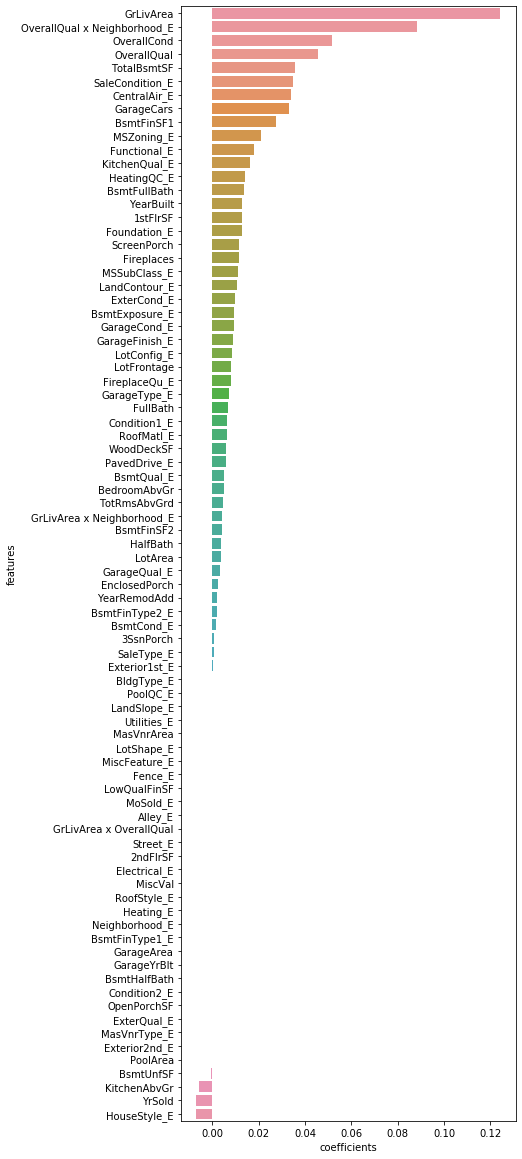

In [18]:
alphasC = np.linspace(0.0001, 0.005, num=100)
lassoC = myLassoCV(
    X_trainC1_scaled, 
    y_trainC1, 
    X_testC1_scaled, 
    y_testC1, 
    alphasC, 
    quantandqualE + CrossedFeatures)

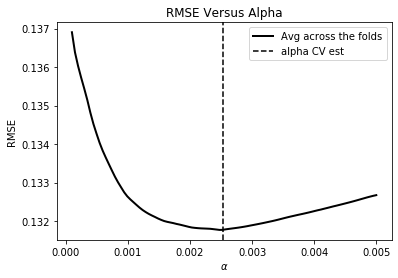

In [19]:
# Plot the average RMSE across each of the 5 test folds as alpha varies.

plotRMSEVersusAlpha(lassoC.alphas_, lassoC.alpha_, lassoC.mse_path_, -1)

In [20]:
testWithCrossTerms = test.copy()
selCrossFea = ['GrLivArea', 'OverallQual', 'Neighborhood_E']
testWithCrossTerms, CrossedFeatures = addCrossTerms(testWithCrossTerms, selCrossFea)
print(CrossedFeatures)
testWithCrossTerms.head()

['GrLivArea x OverallQual', 'GrLivArea x Neighborhood_E', 'OverallQual x Neighborhood_E']


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,LandSlope_E,Neighborhood_E,Condition1_E,Condition2_E,BldgType_E,HouseStyle_E,RoofStyle_E,RoofMatl_E,Exterior1st_E,Exterior2nd_E,MasVnrType_E,ExterQual_E,ExterCond_E,Foundation_E,BsmtQual_E,BsmtCond_E,BsmtExposure_E,BsmtFinType1_E,BsmtFinType2_E,Heating_E,HeatingQC_E,CentralAir_E,Electrical_E,KitchenQual_E,Functional_E,FireplaceQu_E,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,MoSold_E,SaleType_E,SaleCondition_E,GrLivArea x OverallQual,GrLivArea x Neighborhood_E,OverallQual x Neighborhood_E
0,1461,SC20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,...,1,10,2,5,4,5,2,3,12,14,2,2,5,4,3,4,2,4,4,6,3,2,5,2,7,2,6,2,5,6,3,1,2,3,5,6,5,4480,8960,50
1,1462,SC20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,...,1,10,4,5,4,5,4,3,6,3,3,2,5,4,3,4,2,5,5,6,3,2,5,3,7,2,6,2,5,6,3,1,5,4,5,6,5,7974,13290,60
2,1463,SC60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,...,1,14,4,5,4,7,2,3,12,14,2,2,5,6,4,4,2,7,5,6,4,2,5,2,7,4,6,4,5,6,3,1,2,3,7,6,5,8145,22806,70
3,1464,SC60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,...,1,14,4,5,4,7,2,3,12,14,3,2,5,6,3,4,2,7,5,6,5,2,5,3,7,5,6,4,5,6,3,1,5,3,5,6,5,9624,22456,84
4,1465,SC120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,...,1,23,4,5,5,5,2,3,9,9,2,3,5,6,4,4,2,5,5,6,5,2,5,3,7,2,6,3,5,6,3,1,5,3,2,6,5,10240,29440,184


In [25]:
X_trainC_scaled_final, X_testC_scaled_final = checkRanksofFeatureMatricesNoSplit(
    trainWithCrossTerms, testWithCrossTerms, quantandqualE + CrossedFeatures, myStandardScaler, -2, 3)

(1460, 82)
82
(1459, 82)
81


                        features  coefficients
14                     GrLivArea      0.125933
81  OverallQual x Neighborhood_E      0.082487
3                    OverallCond      0.049690
2                    OverallQual      0.045954
10                   TotalBsmtSF      0.040020
24                    GarageCars      0.032115
78               SaleCondition_E      0.031428
7                     BsmtFinSF1      0.027381
63                  CentralAir_E      0.026570
66                  Functional_E      0.020186
35                    MSZoning_E      0.019387
71                  GarageCond_E      0.015149
1                        LotArea      0.015000
30                   ScreenPorch      0.014720
4                      YearBuilt      0.014447
62                   HeatingQC_E      0.014096
65                 KitchenQual_E      0.013670
11                      1stFlrSF      0.011679
22                    Fireplaces      0.010638
34                  MSSubClass_E      0.010618
15           

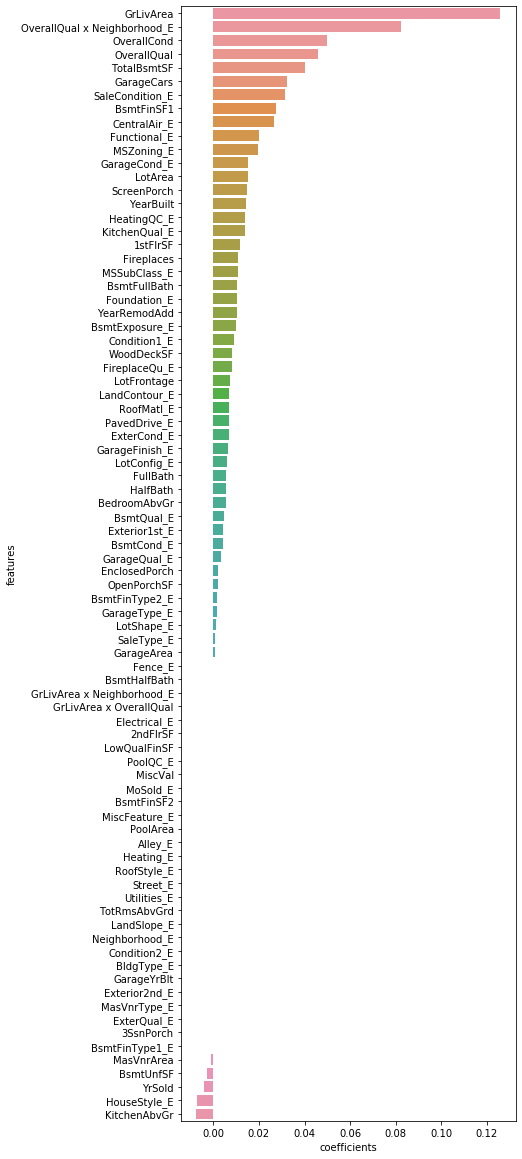

In [26]:
lassoCFinal = myLassoCVFinal(
    X_trainC_scaled_final, 
    trainWithCrossTerms['SalePrice'], 
    alphasC, 
    quantandqualE + CrossedFeatures)

In [27]:
testWithCrossTermsFinal = testWithCrossTerms.copy()
testWithCrossTermsFinal = modelPredict(
    X_testC_scaled_final, 
    lassoCFinal, 
    testWithCrossTermsFinal, 
    'lassoCrossTerms', 
    True)
testWithCrossTermsFinal.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Neighborhood_E,Condition1_E,Condition2_E,BldgType_E,HouseStyle_E,RoofStyle_E,RoofMatl_E,Exterior1st_E,Exterior2nd_E,MasVnrType_E,ExterQual_E,ExterCond_E,Foundation_E,BsmtQual_E,BsmtCond_E,BsmtExposure_E,BsmtFinType1_E,BsmtFinType2_E,Heating_E,HeatingQC_E,CentralAir_E,Electrical_E,KitchenQual_E,Functional_E,FireplaceQu_E,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,MoSold_E,SaleType_E,SaleCondition_E,GrLivArea x OverallQual,GrLivArea x Neighborhood_E,OverallQual x Neighborhood_E,SalePrice
0,1461,SC20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,...,10,2,5,4,5,2,3,12,14,2,2,5,4,3,4,2,4,4,6,3,2,5,2,7,2,6,2,5,6,3,1,2,3,5,6,5,4480,8960,50,117765.498636
1,1462,SC20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,...,10,4,5,4,5,4,3,6,3,3,2,5,4,3,4,2,5,5,6,3,2,5,3,7,2,6,2,5,6,3,1,5,4,5,6,5,7974,13290,60,160245.953195
2,1463,SC60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,...,14,4,5,4,7,2,3,12,14,2,2,5,6,4,4,2,7,5,6,4,2,5,2,7,4,6,4,5,6,3,1,2,3,7,6,5,8145,22806,70,176762.714317
3,1464,SC60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,...,14,4,5,4,7,2,3,12,14,3,2,5,6,3,4,2,7,5,6,5,2,5,3,7,5,6,4,5,6,3,1,5,3,5,6,5,9624,22456,84,197824.293133
4,1465,SC120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,...,23,4,5,5,5,2,3,9,9,2,3,5,6,4,4,2,5,5,6,5,2,5,3,7,2,6,3,5,6,3,1,5,3,2,6,5,10240,29440,184,206664.975503


In [4]:
LassoOutliersClipped = pd.read_csv('/home/seasnake/Desktop/Kaggle_Housing/sublassoOutliersClipped.csv')
LassoExpMidCheap = pd.read_csv('/home/seasnake/Desktop/Kaggle_Housing/subLast.csv')
Ensemble1 = pd.read_csv('/home/seasnake/Desktop/Kaggle_Housing/subLastReally.csv')
Ensemble3 = pd.read_csv('/home/seasnake/Desktop/Kaggle_Housing/subEnsemble3.csv')
LassoCrossTerms = pd.read_csv('/home/seasnake/Desktop/Kaggle_Housing/sublassoCrossTerms.csv')

testCompare4 = LassoOutliersClipped.copy()
testCompare4 = testCompare4.rename(columns={'SalePrice' : 'LassoOutClip'})
testCompare4 = testCompare4.merge(LassoExpMidCheap, on=['Id'])
testCompare4 = testCompare4.rename(columns={'SalePrice' : 'LassoExpMidCheap'})
testCompare4 = testCompare4.merge(LassoCrossTerms, on=['Id'])
testCompare4 = testCompare4.rename(columns={'SalePrice' : 'LassoCross'})
testCompare4 = testCompare4.merge(Ensemble3, on=['Id'])
testCompare4 = testCompare4.rename(columns={'SalePrice' : 'Ensemble3'})
testCompare4['SalePrice'] = testCompare4.apply(
    lambda row: 0.5*row['LassoCross'] + 0.5*row['LassoExpMidCheap'], axis=1 )
testCompare4['Diff'] = testCompare4.apply(
    lambda row: abs(row['Ensemble3'] - row['SalePrice']), axis=1 )
testCompare4 = testCompare4.sort_values('Diff', ascending = False)
testCompare4.head(n=100)

,Id,LassoOutClip,LassoExpMidCheap,LassoCross,Ensemble3,SalePrice,Diff
1089,2550,507641.652749,301712.643701,474040.828550,396276.942175,387876.736126,8400.206050
510,1971,513691.576570,508246.954067,534049.856236,516058.835235,521148.405152,5089.569917
203,1664,540553.515361,536911.671984,560279.912545,543664.192968,548595.792264,4931.599296
831,2292,426858.389617,435339.863259,444930.342180,435617.114579,440135.102719,4517.988141
1168,2629,469553.996050,524967.669524,487088.417168,501644.438066,506028.043346,4383.605280
1222,2683,455429.762619,514662.309751,472389.874471,489286.064148,493526.092111,4240.027963
514,1975,517673.841129,508806.507980,533741.197572,517257.013665,521273.852776,4016.839111
834,2295,484031.747418,462898.332390,499845.475815,477418.472003,481371.904103,3953.432099
803,2264,465706.955354,434340.349751,480472.292269,453714.986781,457406.321010,3691.334229
1170,2631,469611.585178,464350.953645,484236.449459,470637.485482,474293.701552,3656.216070


In [7]:
SubmissionEnsemble3 = testCompare4[['Id', 'SalePrice']]
SubmissionEnsemble3 = SubmissionEnsemble3.sort_values('Id')
SubmissionEnsemble3.to_csv('/home/seasnake/Desktop/Kaggle_Housing/subEnsemble2.csv', index=False)
SubmissionEnsemble3.head()

,Id,SalePrice
0,1461,118909.297743
1,1462,161900.716128
2,1463,179552.822393
3,1464,200201.912092
4,1465,196870.161642
